# Math 251 Classification Project

In [1]:
import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time

#from scipy.stats import multivariate_t
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
import torch
import torch.nn as nn

from scipy.stats import lognorm
import statsmodels.api as sm

from sklearn.metrics import classification_report,confusion_matrix

## 1. Preparation: Import & Check data

**Read in the csv file as a dataframe called data**

In [2]:
data = pd.read_csv('data/smoking_driking_dataset_Ver01.csv')

**Check the info() of the data**

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991346 entries, 0 to 991345
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sex               991346 non-null  object 
 1   age               991346 non-null  int64  
 2   height            991346 non-null  int64  
 3   weight            991346 non-null  int64  
 4   waistline         991346 non-null  float64
 5   sight_left        991346 non-null  float64
 6   sight_right       991346 non-null  float64
 7   hear_left         991346 non-null  float64
 8   hear_right        991346 non-null  float64
 9   SBP               991346 non-null  float64
 10  DBP               991346 non-null  float64
 11  BLDS              991346 non-null  float64
 12  tot_chole         991346 non-null  float64
 13  HDL_chole         991346 non-null  float64
 14  LDL_chole         991346 non-null  float64
 15  triglyceride      991346 non-null  float64
 16  hemoglobin        99

**Check the head of data**

In [4]:
data.head()

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
0,Male,35,170,75,90.0,1.0,1.0,1.0,1.0,120.0,...,126.0,92.0,17.1,1.0,1.0,21.0,35.0,40.0,1.0,Y
1,Male,30,180,80,89.0,0.9,1.2,1.0,1.0,130.0,...,148.0,121.0,15.8,1.0,0.9,20.0,36.0,27.0,3.0,N
2,Male,40,165,75,91.0,1.2,1.5,1.0,1.0,120.0,...,74.0,104.0,15.8,1.0,0.9,47.0,32.0,68.0,1.0,N
3,Male,50,175,80,91.0,1.5,1.2,1.0,1.0,145.0,...,104.0,106.0,17.6,1.0,1.1,29.0,34.0,18.0,1.0,N
4,Male,50,165,60,80.0,1.0,1.2,1.0,1.0,138.0,...,117.0,104.0,13.8,1.0,0.8,19.0,12.0,25.0,1.0,N


In [5]:
data.shape

(991346, 24)

**Check missing values**

In [6]:
data.isna().sum()

sex                 0
age                 0
height              0
weight              0
waistline           0
sight_left          0
sight_right         0
hear_left           0
hear_right          0
SBP                 0
DBP                 0
BLDS                0
tot_chole           0
HDL_chole           0
LDL_chole           0
triglyceride        0
hemoglobin          0
urine_protein       0
serum_creatinine    0
SGOT_AST            0
SGOT_ALT            0
gamma_GTP           0
SMK_stat_type_cd    0
DRK_YN              0
dtype: int64

In [7]:
data.nunique()

sex                    2
age                   14
height                13
weight                24
waistline            737
sight_left            24
sight_right           24
hear_left              2
hear_right             2
SBP                  171
DBP                  127
BLDS                 498
tot_chole            474
HDL_chole            223
LDL_chole            432
triglyceride        1657
hemoglobin           190
urine_protein          6
serum_creatinine     183
SGOT_AST             568
SGOT_ALT             594
gamma_GTP            940
SMK_stat_type_cd       3
DRK_YN                 2
dtype: int64

**Duplication**

In [8]:
# Check duplicated data points
data[data.duplicated()].shape

(26, 24)

In [9]:
# Remove duplications
data=data.drop_duplicates(keep='first')
data[data.duplicated()].shape

(0, 24)

In [10]:
# After remove duplications, there are 991,320 observations in totla.
data.shape

(991320, 24)

# 2. Variables & Data Cleaning

**(1) Variable name, value and generate reponse y**

**A.Change variable name**

In [11]:
data=data.rename({'SMK_stat_type_cd': 'smoker',"DRK_YN":'drinker'},axis='columns')

**B. Change Variable values**

**'sex': Female=1, Male=0**

**'drinker': Y=1, N=0**

**'hear_left' & 'hear_right': 2=0 (abornal)**

In [12]:
data.loc[data['sex']=='Female','sex']=1
data.loc[data['sex']=='Male','sex']=0
data['sex'] = data['sex'].astype('int')

data.loc[data['drinker']=='Y','drinker']=1
data.loc[data['drinker']=='N','drinker']=0

data.loc[data['hear_left']==2,'hear_left']=0
data.loc[data['hear_right']==2,'hear_right']=0

**C.Generate Response smoker_drinker**

smoker=1/2 (never/quit), drinker=no 0, smoker_drinker=0 (not smaker, not drinker)

smoker=3 (smoker), drinker=no 0, smoker_drinker=1 (smoker, not drinker)

smoker=1/2, drinker=yes 1, smoker_drinker=2 (not smoker, drinker)

smoker=3, drinker=yes 1, smoker_drinker=3 (smoker and drinker)

In [13]:
data['smoker_drinker']=0

data.loc[(data['smoker']==1) & (data['drinker']==0),'smoker_drinker']=0
data.loc[((data['smoker']==2) | (data['smoker']==3)) & (data['drinker']==0),'smoker_drinker']=1
data.loc[(data['smoker']==1) & (data['drinker']==1),'smoker_drinker']=2
data.loc[((data['smoker']==2) | (data['smoker']==3)) & (data['drinker']==1),'smoker_drinker']=3

np.unique(data['smoker_drinker'])

array([0, 1, 2, 3])

In [14]:

# Change this value to select different Y. 3 options: 'drinker', 'smoker', 'smoker_drinker'
Ynames = ['drinker', 'smoker', 'smoker_drinker']
Y_col_name = Ynames[1]
Y_class_num = int(data[Y_col_name].max()+1)

In [15]:
# Distribution of each category of y
data[Y_col_name].value_counts(normalize=True)

1.0    0.607706
3.0    0.215818
2.0    0.176476
Name: smoker, dtype: float64

In [16]:
# Drop 'urine_protein' and unused Y variables. Won't use them in the following
data=data.drop(['urine_protein'],axis=1)

**(2) Summary of variables**

In [17]:
# Summary of X
data[['age', 'height','weight', 'waistline', 'sight_left', 'sight_right', 'SBP', 'DBP','BLDS','tot_chole','HDL_chole',
         'LDL_chole','triglyceride', 'hemoglobin','serum_creatinine','SGOT_AST','SGOT_ALT','gamma_GTP']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,991320.0,47.614529,14.181346,20.0,35.0,45.0,60.0,85.0
height,991320.0,162.240563,9.282922,130.0,155.0,160.0,170.0,190.0
weight,991320.0,63.283884,12.514101,25.0,55.0,60.0,70.0,140.0
waistline,991320.0,81.233255,11.850296,8.0,74.1,81.0,87.8,999.0
sight_left,991320.0,0.980833,0.605954,0.1,0.7,1.0,1.2,9.9
sight_right,991320.0,0.978428,0.604779,0.1,0.7,1.0,1.2,9.9
SBP,991320.0,122.432360,14.543083,67.0,112.0,120.0,131.0,273.0
DBP,991320.0,76.052549,9.889334,32.0,70.0,76.0,82.0,185.0
BLDS,991320.0,100.424305,24.179852,25.0,88.0,96.0,105.0,852.0
tot_chole,991320.0,195.556769,38.660092,30.0,169.0,193.0,219.0,2344.0


**(3) Abnormal values**

In [18]:
# eye sight: 9.9 means blind, so gives it 0 value.
data.loc[data['sight_left']==9.9, 'sight_left']=0
data.loc[data['sight_right']==9.9, 'sight_right']=0

In [19]:
# Remove observations in which waistline==999
data = data[data['waistline'] !=999]
data.shape

(991263, 24)

In [20]:
# There are 991,263 observations in total
data = data.reset_index(drop=True)
data_conts = data[['age', 'height','weight', 'waistline', 'sight_left', 'sight_right', 'SBP', 'DBP','BLDS','tot_chole','HDL_chole',
         'LDL_chole','triglyceride', 'hemoglobin','serum_creatinine','SGOT_AST','SGOT_ALT','gamma_GTP']]
data_conts.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,991263.0,47.615552,14.181086,20.0,35.0,45.0,60.0,85.0
height,991263.0,162.240687,9.283100,130.0,155.0,160.0,170.0,190.0
weight,991263.0,63.283997,12.514296,25.0,55.0,60.0,70.0,140.0
waistline,991263.0,81.180481,9.591700,8.0,74.1,81.0,87.8,149.1
sight_left,991263.0,0.949688,0.344997,0.0,0.7,1.0,1.2,2.5
sight_right,991263.0,0.947355,0.343527,0.0,0.7,1.0,1.2,2.5
SBP,991263.0,122.433242,14.542873,67.0,112.0,120.0,131.0,273.0
DBP,991263.0,76.053114,9.889155,32.0,70.0,76.0,82.0,185.0
BLDS,991263.0,100.425394,24.180038,25.0,88.0,96.0,105.0,852.0
tot_chole,991263.0,195.554860,38.658738,30.0,169.0,193.0,219.0,2344.0


In [21]:
data.tail()

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,smoker,drinker,smoker_drinker
991258,0,45,175,80,92.1,1.5,1.5,1.0,1.0,114.0,...,125.0,132.0,15.0,1.0,26.0,36.0,27.0,1.0,0,0
991259,0,35,170,75,86.0,1.0,1.5,1.0,1.0,119.0,...,84.0,45.0,15.8,1.1,14.0,17.0,15.0,1.0,0,0
991260,1,40,155,50,68.0,1.0,0.7,1.0,1.0,110.0,...,77.0,157.0,14.3,0.8,30.0,27.0,17.0,3.0,1,3
991261,0,25,175,60,72.0,1.5,1.0,1.0,1.0,119.0,...,73.0,53.0,14.5,0.8,21.0,14.0,17.0,1.0,0,0
991262,0,50,160,70,90.5,1.0,1.5,1.0,1.0,133.0,...,153.0,163.0,15.8,0.9,24.0,43.0,36.0,3.0,1,3


In [22]:
data_conts.shape

(991263, 18)

## 3. Standardization/Normalization

In [23]:
# Standardization of X
scaler = StandardScaler()
scaler.fit(data_conts)
scaled_features = scaler.transform(data_conts)

In [24]:
data_X = pd.DataFrame(scaled_features,columns=data_conts.columns)
data_X = pd.concat([data_X, data[['sex', 'hear_left', 'hear_right']]], axis=1)
data_X.head()

,age,height,weight,waistline,sight_left,sight_right,SBP,DBP,BLDS,tot_chole,...,LDL_chole,triglyceride,hemoglobin,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,sex,hear_left,hear_right
0,-0.889605,0.835854,0.936210,0.919495,0.145834,0.153250,-0.167315,0.399113,-0.058949,-0.066088,...,0.361651,-0.392753,1.810919,0.290333,-0.212391,0.351362,0.056765,0,1.0,1.0
1,-1.242187,1.913081,1.335753,0.815238,-0.144024,0.735446,0.520307,0.601355,0.230546,0.839271,...,0.975435,-0.108982,0.990663,0.082235,-0.254954,0.389371,-0.201044,0,1.0,1.0
2,-0.537022,0.297241,0.936210,1.023752,0.725550,1.608740,-0.167315,-0.612097,-0.100306,-1.540529,...,-1.089111,-0.275331,0.990663,0.082235,0.894266,0.237334,0.612047,0,1.0,1.0
3,0.168143,1.374468,1.335753,1.023752,1.595124,0.735446,1.551741,1.106959,-0.224375,0.140852,...,-0.252133,-0.255760,2.126403,0.498430,0.128119,0.313353,-0.379527,0,1.0,1.0
4,0.168143,0.297241,-0.262420,-0.123073,0.145834,0.735446,1.070405,0.601355,0.023764,0.089117,...,0.110558,-0.275331,-0.271270,-0.125863,-0.297518,-0.522850,-0.240707,0,1.0,1.0


In [25]:
data_y = data[Y_col_name]

In [26]:
data = pd.concat([data_X, data_y], axis=1)
data[Y_col_name] = data[Y_col_name].astype('int64')
data

,age,height,weight,waistline,sight_left,sight_right,SBP,DBP,BLDS,tot_chole,...,triglyceride,hemoglobin,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,sex,hear_left,hear_right,smoker
0,-0.889605,0.835854,0.936210,0.919495,0.145834,0.153250,-0.167315,0.399113,-0.058949,-0.066088,...,-0.392753,1.810919,0.290333,-0.212391,0.351362,0.056765,0,1.0,1.0,1
1,-1.242187,1.913081,1.335753,0.815238,-0.144024,0.735446,0.520307,0.601355,0.230546,0.839271,...,-0.108982,0.990663,0.082235,-0.254954,0.389371,-0.201044,0,1.0,1.0,3
2,-0.537022,0.297241,0.936210,1.023752,0.725550,1.608740,-0.167315,-0.612097,-0.100306,-1.540529,...,-0.275331,0.990663,0.082235,0.894266,0.237334,0.612047,0,1.0,1.0,1
3,0.168143,1.374468,1.335753,1.023752,1.595124,0.735446,1.551741,1.106959,-0.224375,0.140852,...,-0.255760,2.126403,0.498430,0.128119,0.313353,-0.379527,0,1.0,1.0,1
4,0.168143,0.297241,-0.262420,-0.123073,0.145834,0.735446,1.070405,0.601355,0.023764,0.089117,...,-0.275331,-0.271270,-0.125863,-0.297518,-0.522850,-0.240707,0,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991258,-0.184440,1.374468,1.335753,1.138435,1.595124,1.608740,-0.579889,0.399113,-0.513870,0.063249,...,-0.001345,0.485890,0.290333,0.000428,0.389371,-0.201044,0,1.0,1.0,1
991259,-0.889605,0.835854,0.936210,0.502468,0.145834,1.608740,-0.236077,0.702476,-0.720652,-1.618131,...,-0.852658,0.990663,0.498430,-0.510336,-0.332804,-0.439022,0,1.0,1.0,1
991260,-0.537022,-0.779986,-1.061506,-1.374156,0.145834,-0.720044,-0.854938,-0.612097,-0.431157,0.244321,...,0.243285,0.044213,-0.125863,0.170683,0.047288,-0.399359,1,1.0,1.0,3
991261,-1.594770,1.374468,-0.262420,-0.957128,1.595124,0.153250,-0.236077,-0.207613,-1.299643,-1.902672,...,-0.774377,0.170406,-0.125863,-0.212391,-0.446832,-0.399359,0,1.0,1.0,1


In [27]:
data.head()

,age,height,weight,waistline,sight_left,sight_right,SBP,DBP,BLDS,tot_chole,...,triglyceride,hemoglobin,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,sex,hear_left,hear_right,smoker
0,-0.889605,0.835854,0.936210,0.919495,0.145834,0.153250,-0.167315,0.399113,-0.058949,-0.066088,...,-0.392753,1.810919,0.290333,-0.212391,0.351362,0.056765,0,1.0,1.0,1
1,-1.242187,1.913081,1.335753,0.815238,-0.144024,0.735446,0.520307,0.601355,0.230546,0.839271,...,-0.108982,0.990663,0.082235,-0.254954,0.389371,-0.201044,0,1.0,1.0,3
2,-0.537022,0.297241,0.936210,1.023752,0.725550,1.608740,-0.167315,-0.612097,-0.100306,-1.540529,...,-0.275331,0.990663,0.082235,0.894266,0.237334,0.612047,0,1.0,1.0,1
3,0.168143,1.374468,1.335753,1.023752,1.595124,0.735446,1.551741,1.106959,-0.224375,0.140852,...,-0.255760,2.126403,0.498430,0.128119,0.313353,-0.379527,0,1.0,1.0,1
4,0.168143,0.297241,-0.262420,-0.123073,0.145834,0.735446,1.070405,0.601355,0.023764,0.089117,...,-0.275331,-0.271270,-0.125863,-0.297518,-0.522850,-0.240707,0,1.0,1.0,1


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991263 entries, 0 to 991262
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   age               991263 non-null  float64
 1   height            991263 non-null  float64
 2   weight            991263 non-null  float64
 3   waistline         991263 non-null  float64
 4   sight_left        991263 non-null  float64
 5   sight_right       991263 non-null  float64
 6   SBP               991263 non-null  float64
 7   DBP               991263 non-null  float64
 8   BLDS              991263 non-null  float64
 9   tot_chole         991263 non-null  float64
 10  HDL_chole         991263 non-null  float64
 11  LDL_chole         991263 non-null  float64
 12  triglyceride      991263 non-null  float64
 13  hemoglobin        991263 non-null  float64
 14  serum_creatinine  991263 non-null  float64
 15  SGOT_AST          991263 non-null  float64
 16  SGOT_ALT          99

## 4. EDA

**(1) Response Variable**

/var/folders/20/xzqt7h_959d2_315hxty0g70005b4x/T/ipykernel_68208/3732992656.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  y_plot.set_yticklabels(["Never Smoke", "Previous Smoke", "Active Smoke"])


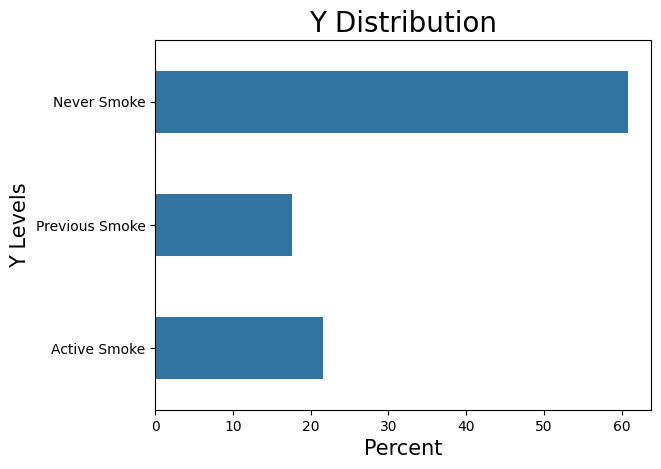

In [29]:
y_plot = sns.countplot(y=Y_col_name,data=data, stat='percent', width=0.5)
y_plot.set_xlabel('Percent', fontsize=15)                                                                                                                                                                                 
y_plot.set_ylabel('Y Levels', fontsize=15)
y_plot.set_title('Y Distribution', fontsize=20)
y_plot.set_yticklabels(["Never Smoke", "Previous Smoke", "Active Smoke"])

plt.show()

**(2) Pairwise Correlation: continuous**

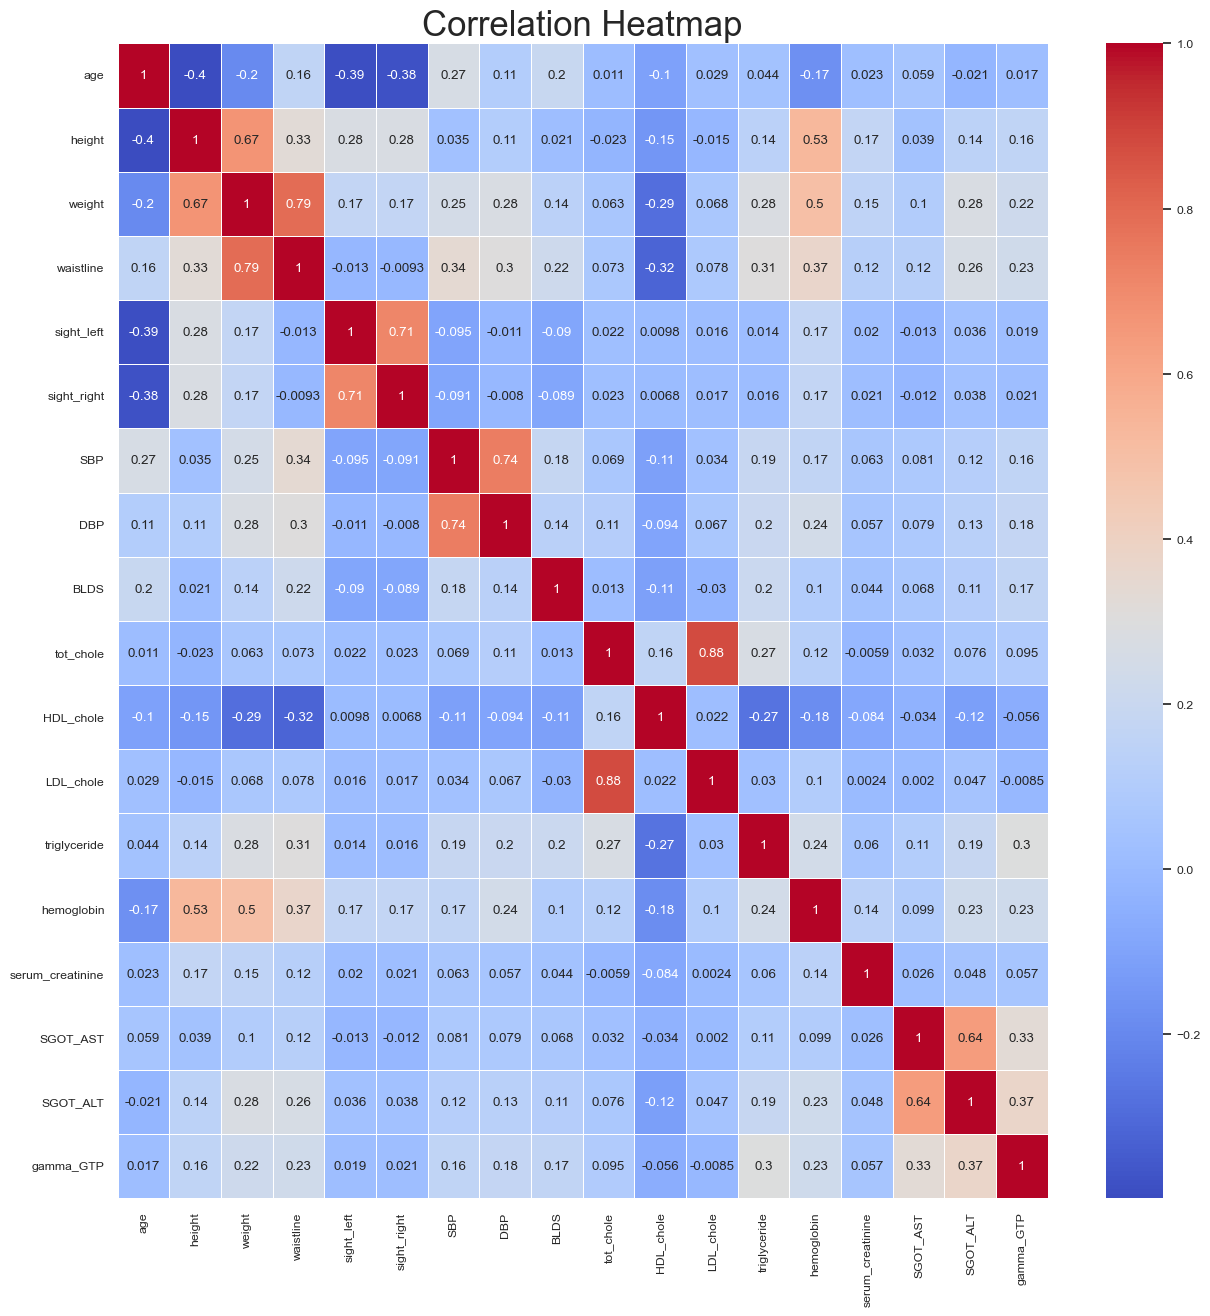

In [30]:
data2=data.copy()
data2=data2.drop(columns=['sex', 'hear_left', 'hear_right', Y_col_name])

corr_matrix = data2.corr()

plt.figure(figsize = (15,15))
sns.set(font_scale=0.8)
sns.heatmap(corr_matrix,annot=True,cmap='coolwarm',linewidths=0.5)
plt.title('Correlation Heatmap',fontsize = 25)

plt.show()

**(3) Normality Test**

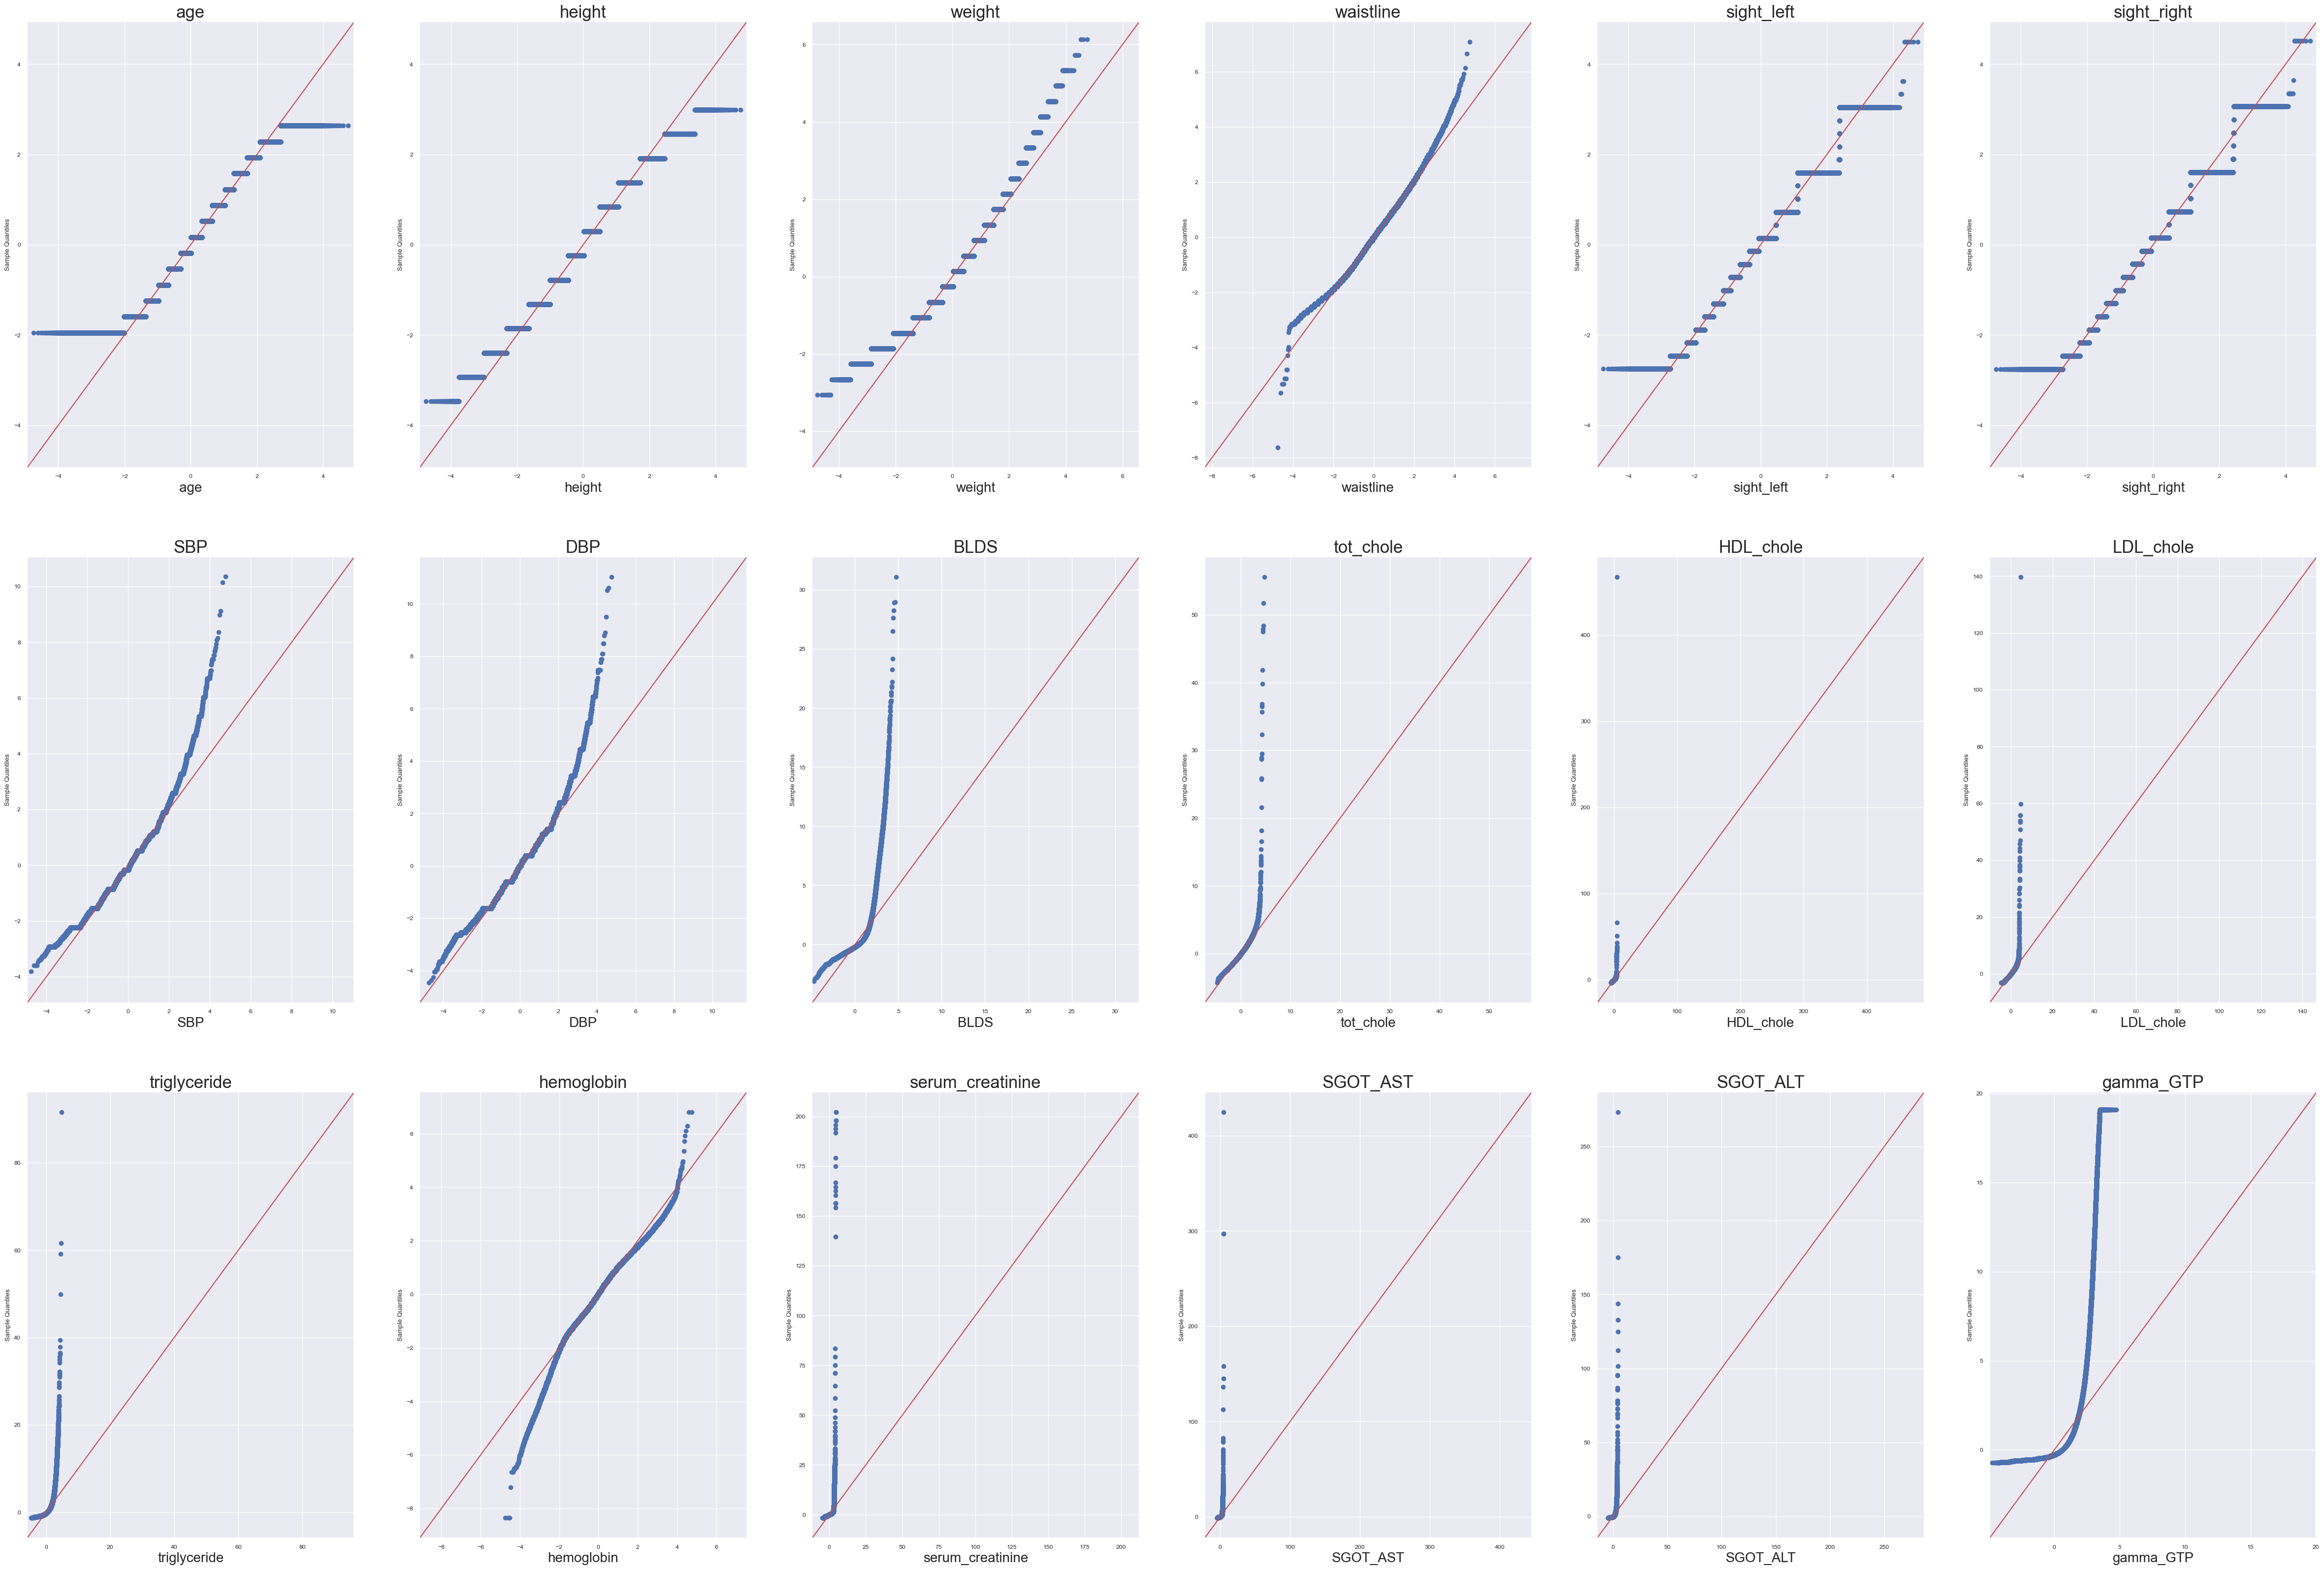

In [31]:
fig, ax =plt.subplots(nrows=3,ncols=6,figsize =(60,40))

columns = ['age', 'height', 'weight', 'waistline', 'sight_left', 'sight_right','SBP', 'DBP', 'BLDS', 'tot_chole',
       'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP']

#create Q-Q plot with 45-degree line added to plot

for r in range(3):
    for c in range(6):
        idx = r * 6 + c
        sm.qqplot(data[columns[idx]], line='45',ax=ax[r,c])
        ax[r,c].set_xlabel(columns[idx], fontsize=20)
        ax[r,c].set_title(columns[idx], fontsize=25)

plt.show()

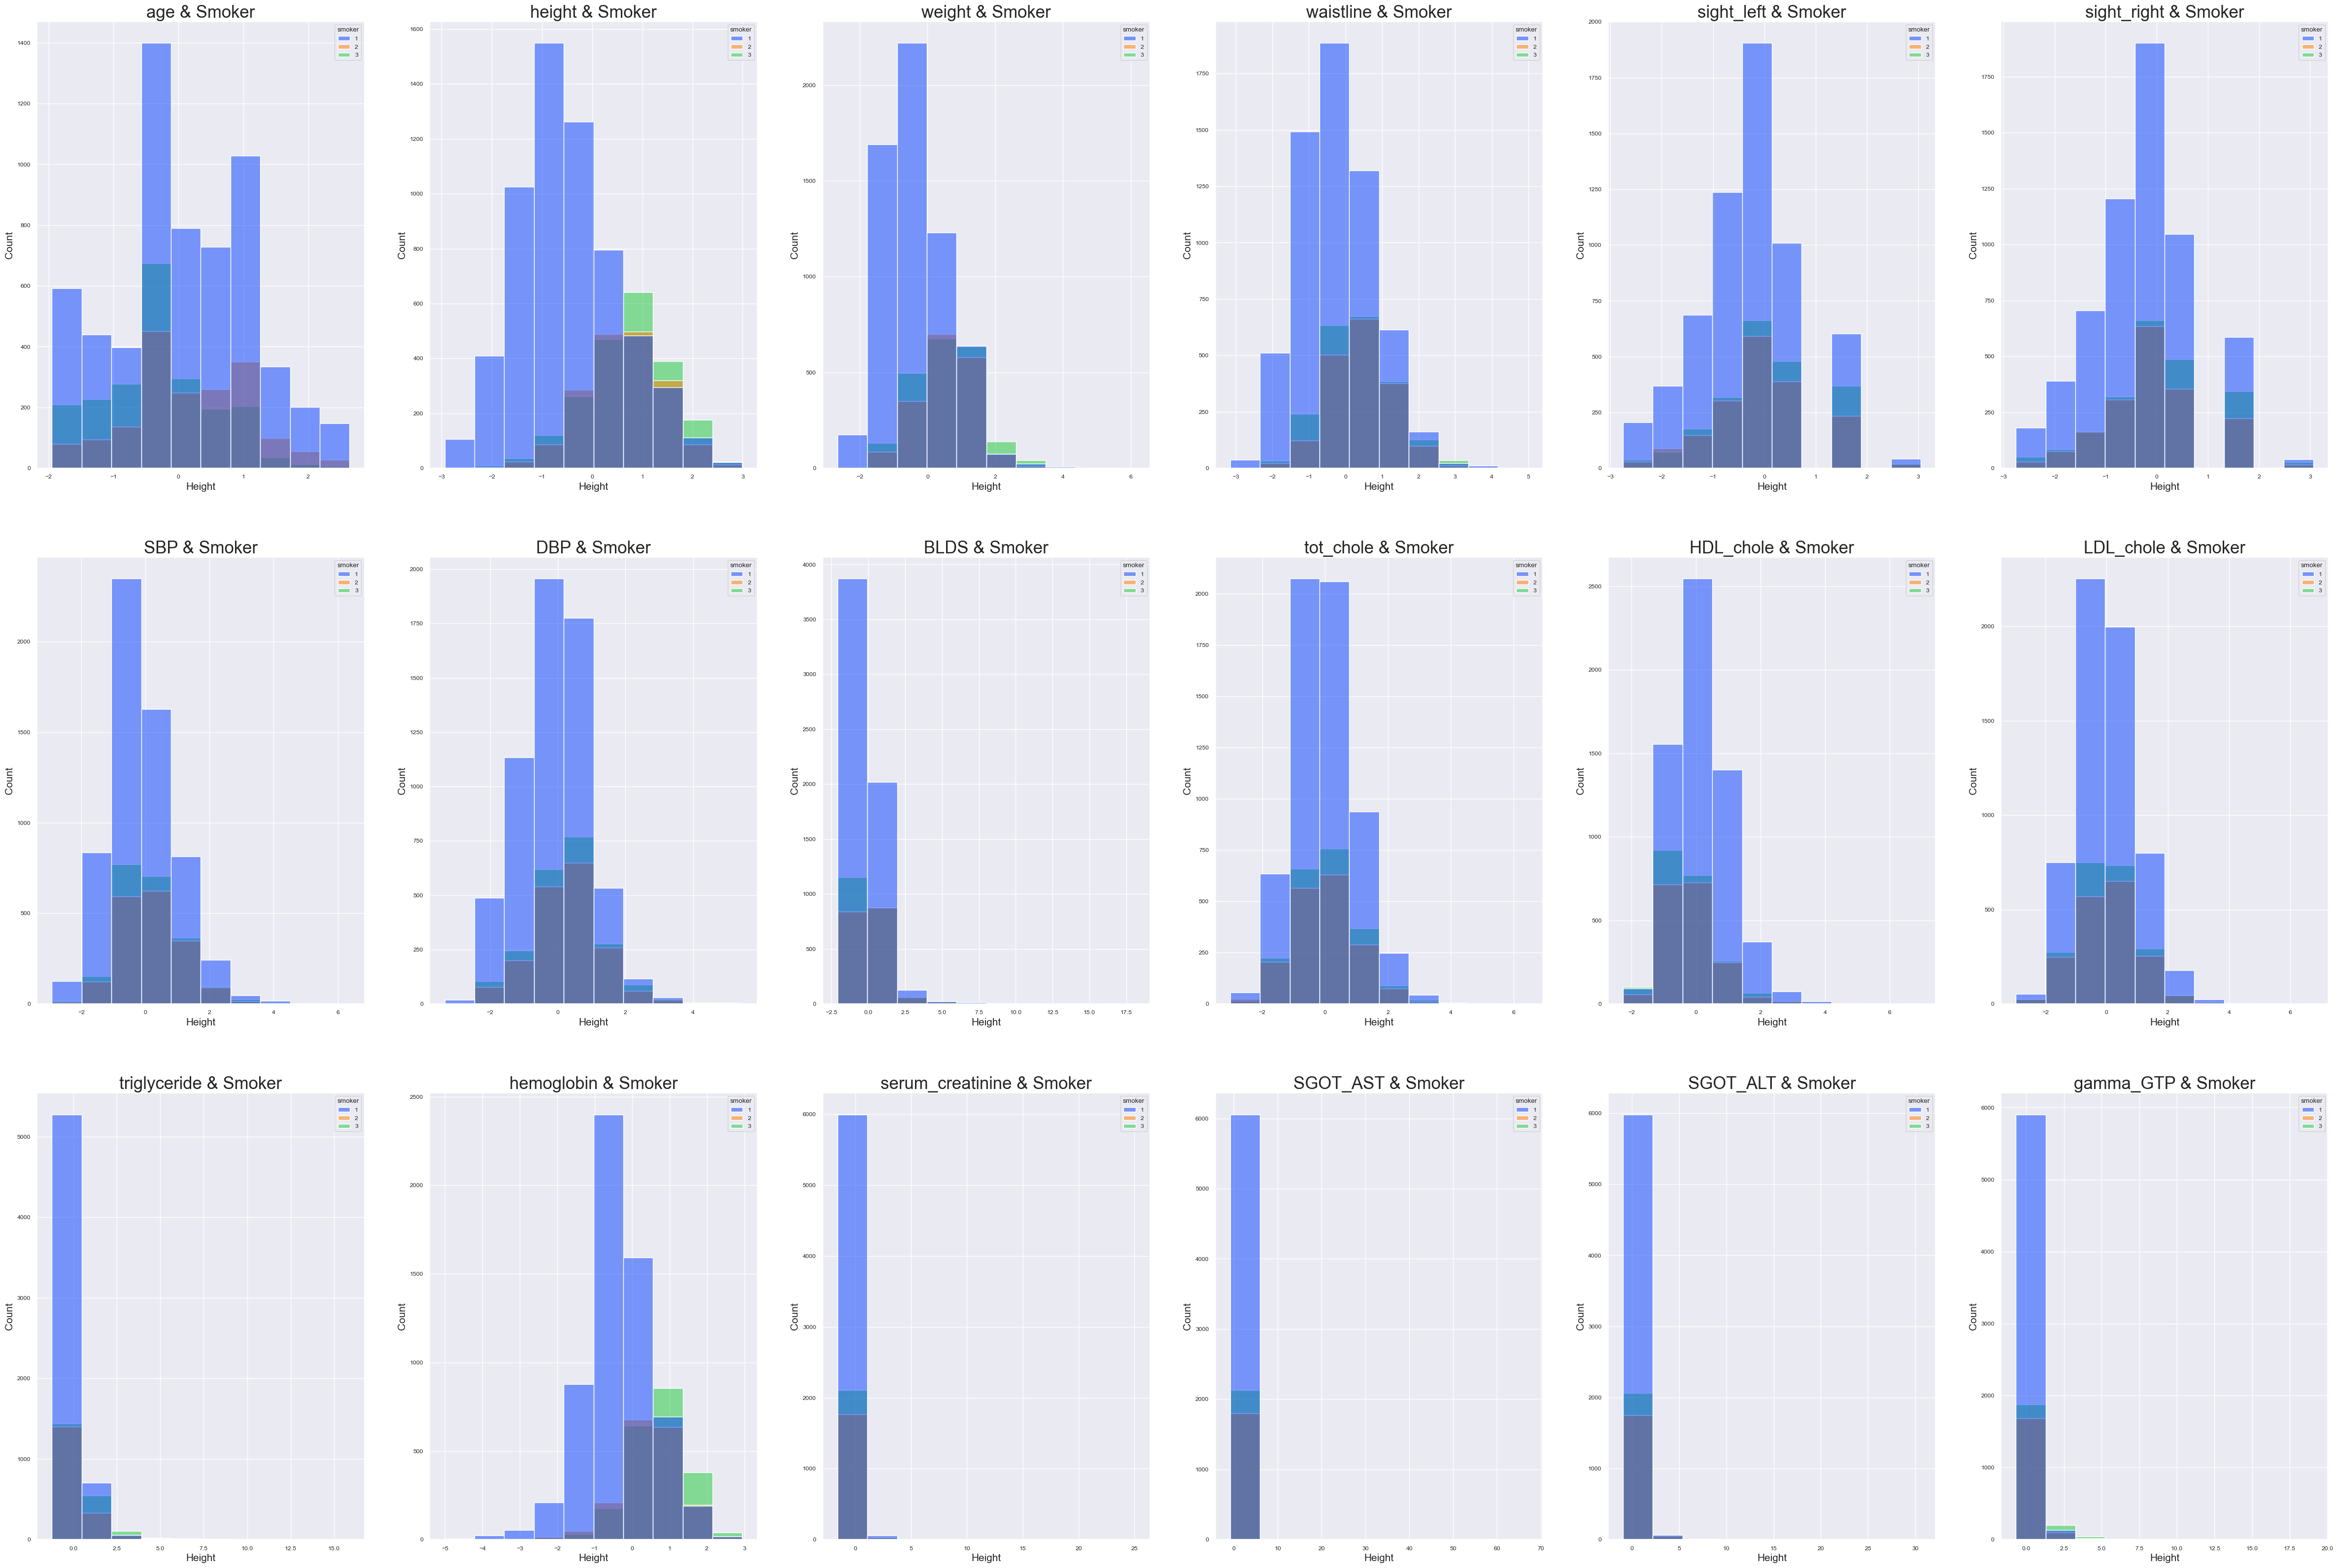

In [32]:
fig, ax =plt.subplots(nrows=3,ncols=6,figsize =(60,40))
plot_sample = data.sample(10000, random_state=1)
for r in range(3):
    for c in range(6):
        idx = r * 6 + c
        a = sns.histplot(data=plot_sample, x=columns[idx], hue=Y_col_name, bins=10, palette='bright',ax=ax[r,c])
        a.set_title(columns[idx]+' & Smoker', fontsize=25)
        a.set_ylabel('Count', fontsize=15)                                                                                                                                                                                 
        a.set_xlabel('Height', fontsize=15)

plt.show()

## 5. Sample and Split: 1st Trial

**Sample 1: random sample 10k observations as training set; random sample 50 test sets, each of which has 1,000 observations**

In [33]:
# Set seed to make the results reproducible
np.random.seed(1000) 

# Get index for 10,000 training data points out of 991,263 observations
training_index = np.random.choice(range(991263), 10000)

In [34]:
# Sample the training data set to contain 10,000 observations for faster propotype
training = data.iloc[training_index]
X_train = training.iloc[:,0:-1]  
y_train = training[Y_col_name]

In [35]:
# Randomly sample 50 test data sets from the rest 990,263 observations. Each contains 1,000 observations
test_pool = data.drop(index=training_index)
X_test = [None]*50
y_test = [None]*50

for i in range(50):  
    testdata=test_pool.sample(n=1000, random_state=i) 
    X_test[i] = testdata.iloc[:,0:-1]
    y_test[i] = testdata[Y_col_name]

In [36]:
y_train.groupby(y_train).count()

smoker
1    6095
2    1735
3    2170
Name: smoker, dtype: int64

## 6. Fit Classification Models: Sample Data 1

## (1) KNN

In [37]:
parameters = {'n_neighbors': [1, 5, 10, 50, 100, 500, 1000], 
              'weights': ['uniform', 'distance']} 
  
knngs = GridSearchCV(neighbors.KNeighborsClassifier(), parameters, cv=10, 
                     scoring='accuracy', return_train_score=False,verbose=1,error_score='raise')
  
# fitting the model for grid search
knngs.fit(X_train, y_train)
knngs.best_params_   

Fitting 10 folds for each of 14 candidates, totalling 140 fits


/Users/chunfengh/Library/Python/3.9/lib/python/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


{'n_neighbors': 50, 'weights': 'distance'}

<Axes: >

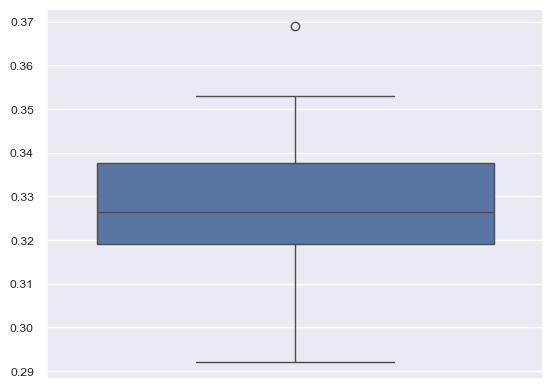

In [38]:
knngs_prediction=[None]*50
knngs_test_err=[None]*50

for i in range(50):
    knngs_prediction[i] = knngs.predict(X_test[i])
    knngs_test_err[i] = sum(y_test[i]!=knngs_prediction[i])/len(X_test[i])
sns.boxplot(knngs_test_err)

In [39]:
knngs_test_err = pd.DataFrame(knngs_test_err, columns = ['test_err'])
model=['KNNGS']*50
knngs_test_err['Model']=model
knngs_test_err.head()

,test_err,Model
0,0.325,KNNGS
1,0.337,KNNGS
2,0.314,KNNGS
3,0.313,KNNGS
4,0.326,KNNGS


## (2) Logistic Regression

In [40]:
lr = LogisticRegression(penalty='l2',max_iter=200,solver='newton-cg')
lr.fit(X_train,y_train)

LogisticRegression(max_iter=200, solver='newton-cg')

<Axes: >

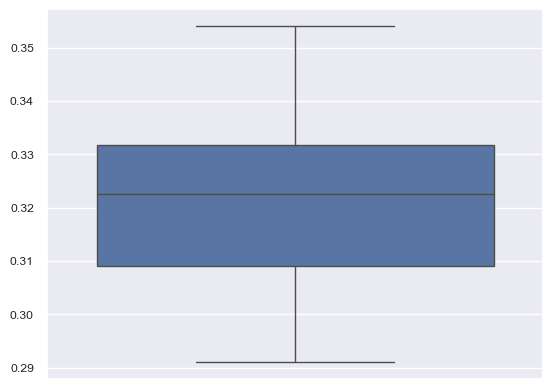

In [41]:
lr_prediction=[None]*50
lr_test_err=[None]*50

for i in range(50):
    lr_prediction[i] = lr.predict(X_test[i])
    lr_test_err[i] = sum(y_test[i]!=lr_prediction[i])/len(X_test[i])
sns.boxplot(lr_test_err)

In [42]:
lr_test_err = pd.DataFrame(lr_test_err, columns = ['test_err'])
model=['LR']*50
lr_test_err['Model']=model
lr_test_err.head()

,test_err,Model
0,0.306,LR
1,0.332,LR
2,0.300,LR
3,0.298,LR
4,0.322,LR


## (3) LDA, QDA, NB

**A. LDA**

In [43]:
lda = LinearDiscriminantAnalysis(store_covariance=True)
lda.fit(X_train,y_train)

LinearDiscriminantAnalysis(store_covariance=True)

<Axes: >

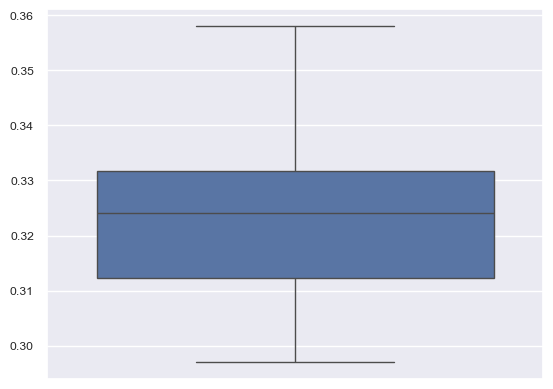

In [44]:
lda_prediction=[None]*50
lda_test_err=[None]*50

for i in range(50):
    lda_prediction[i] = lda.predict(X_test[i])
    lda_test_err[i] = sum(y_test[i]!=lda_prediction[i])/len(X_test[i])
sns.boxplot(lda_test_err)   

In [45]:
lda_test_err = pd.DataFrame(lda_test_err, columns = ['test_err'])
model=['LDA']*50
lda_test_err['Model']=model
lda_test_err.head()

,test_err,Model
0,0.308,LDA
1,0.328,LDA
2,0.308,LDA
3,0.303,LDA
4,0.325,LDA


**B. QDA**

In [46]:
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(X_train,y_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

<Axes: >

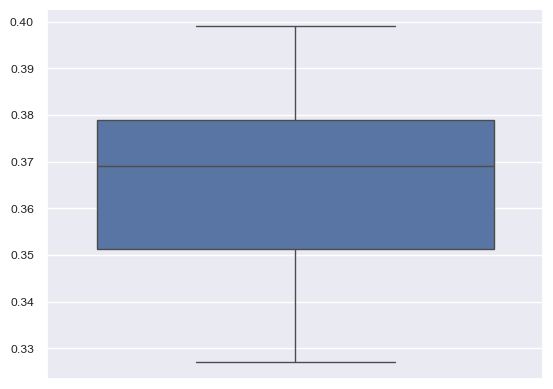

In [47]:
qda_prediction=[None]*50
qda_test_err=[None]*50

for i in range(50):
    qda_prediction[i] = qda.predict(X_test[i])
    qda_test_err[i] = sum(y_test[i]!=qda_prediction[i])/len(X_test[i])
sns.boxplot(qda_test_err)

In [48]:
qda_test_err = pd.DataFrame(qda_test_err, columns = ['test_err'])
model=['QDA']*50
qda_test_err['Model']=model
qda_test_err.head()

,test_err,Model
0,0.349,QDA
1,0.372,QDA
2,0.353,QDA
3,0.349,QDA
4,0.342,QDA


**C. NB**

In [49]:
NB = GaussianNB()
NB.fit(X_train,y_train)

GaussianNB()

<Axes: >

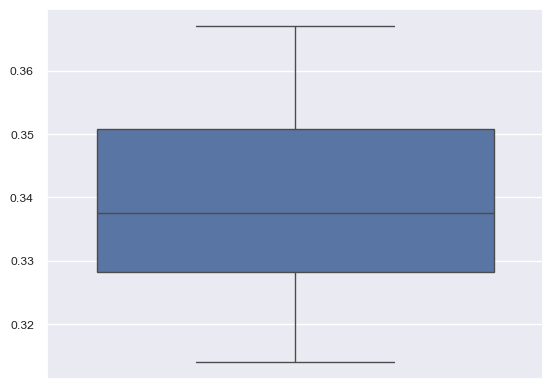

In [50]:
nb_prediction=[None]*50
nb_test_err=[None]*50

for i in range(50):
    nb_prediction[i] = NB.predict(X_test[i])
    nb_test_err[i] = sum(y_test[i]!=nb_prediction[i])/len(X_test[i])
sns.boxplot(nb_test_err)

In [51]:
nb_test_err = pd.DataFrame(nb_test_err, columns = ['test_err'])
model=['NB']*50
nb_test_err['Model']=model
nb_test_err.head()

,test_err,Model
0,0.324,NB
1,0.351,NB
2,0.319,NB
3,0.319,NB
4,0.343,NB


## (4) Tree-based, Bagging, Random Forest, Boosting

**A. Decision Tree**

In [52]:
parameters = {'criterion': ['gini', 'entropy', 'log_loss'],
             'min_samples_split': [2,5,10]} 
dtreegs = GridSearchCV(DecisionTreeClassifier(), parameters, n_jobs=-1, cv=10)
dtreegs.fit(X_train, y_train)
dtreegs.best_params_

{'criterion': 'entropy', 'min_samples_split': 10}

<Axes: >

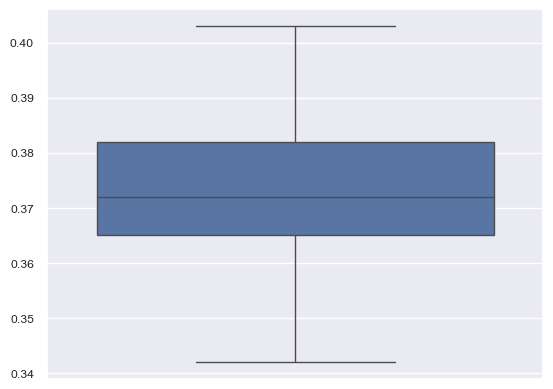

In [53]:
dtreegs_prediction=[None]*50
dtreegs_test_err=[None]*50

for i in range(50):
    dtreegs_prediction[i] = dtreegs.predict(X_test[i])
    dtreegs_test_err[i] = sum(y_test[i]!=dtreegs_prediction[i])/len(X_test[i])
sns.boxplot(dtreegs_test_err)

In [54]:
dtreegs_test_err = pd.DataFrame(dtreegs_test_err, columns = ['test_err'])
model=['DTree']*50
dtreegs_test_err['Model']=model
dtreegs_test_err.head()

,test_err,Model
0,0.365,DTree
1,0.383,DTree
2,0.368,DTree
3,0.348,DTree
4,0.344,DTree


**B. Random Forest**

In [55]:
parameters = {'n_estimators': [5, 10, 100, 500],
             'criterion': ['gini', 'entropy', 'log_loss'],
             'min_samples_split': [2,5,10]} 

rfcgs = GridSearchCV(RandomForestClassifier(), parameters, n_jobs=-1, cv=10)
rfcgs.fit(X_train, y_train)
rfcgs.best_params_

{'criterion': 'gini', 'min_samples_split': 5, 'n_estimators': 500}

<Axes: >

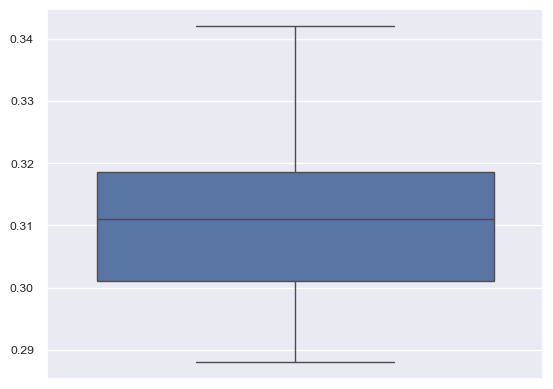

In [56]:
rfcgs_prediction=[None]*50
rfcgs_test_err=[None]*50

for i in range(50):
    rfcgs_prediction[i] = rfcgs.predict(X_test[i])
    rfcgs_test_err[i] = sum(y_test[i]!=rfcgs_prediction[i])/len(X_test[i])
sns.boxplot(rfcgs_test_err)

In [57]:
rfcgs_test_err = pd.DataFrame(rfcgs_test_err, columns = ['test_err'])
model=['RFC']*50
rfcgs_test_err['Model']=model
rfcgs_test_err.head()

,test_err,Model
0,0.304,RFC
1,0.308,RFC
2,0.301,RFC
3,0.294,RFC
4,0.304,RFC


**C. Gradient Boosting Classifier**

In [58]:
parameters = {'n_estimators': [5, 10, 100],
             'min_samples_split': [2,5,10],
             'learning_rate': [0.001,0.01, 0.1, 0.5, 0.9],
              'max_depth': [1,2,3,5]
             } 

gbcgs = GridSearchCV(GradientBoostingClassifier(), parameters, n_jobs=-1, cv=10)
gbcgs.fit(X_train, y_train)
gbcgs.best_params_


{'learning_rate': 0.5,
 'max_depth': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

<Axes: >

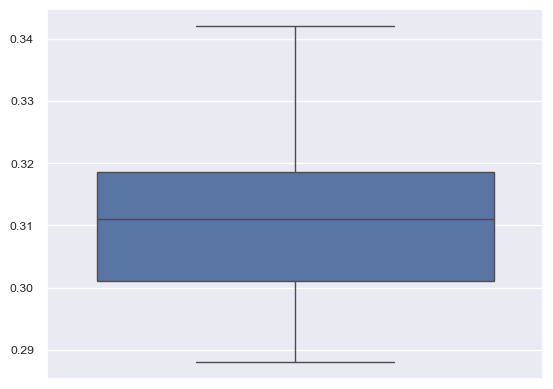

In [59]:
gbcgs_prediction=[None]*50
gbcgs_test_err=[None]*50

for i in range(50):
    gbcgs_prediction[i] = rfcgs.predict(X_test[i])
    gbcgs_test_err[i] = sum(y_test[i]!=rfcgs_prediction[i])/len(X_test[i])

sns.boxplot(gbcgs_test_err)

In [60]:
gbcgs_test_err = pd.DataFrame(gbcgs_test_err, columns = ['test_err'])
model=['GBC']*50
gbcgs_test_err['Model']=model
gbcgs_test_err.head()

,test_err,Model
0,0.304,GBC
1,0.308,GBC
2,0.301,GBC
3,0.294,GBC
4,0.304,GBC


## (5) SVM

In [61]:
parameters = {'C': [0.1,1, 10, 100, 1000], 
              'gamma': [1,0.1,0.01,0.001,0.0001], 
              'kernel': ['rbf'],
             'decision_function_shape': ['ovo']} 

svmgs = GridSearchCV(svm.SVC(), parameters, n_jobs=-1, cv=10)
svmgs.fit(X_train, y_train)
svmgs.best_params_

{'C': 10, 'decision_function_shape': 'ovo', 'gamma': 0.01, 'kernel': 'rbf'}

<Axes: >

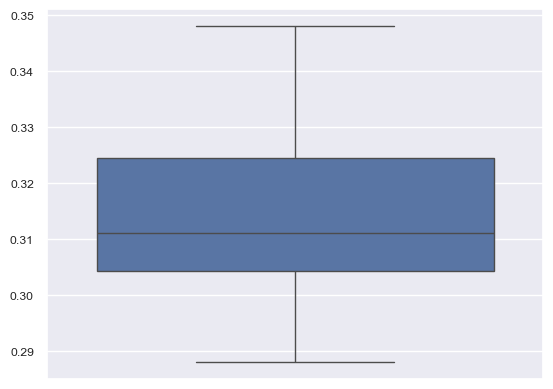

In [62]:
svmgs_prediction=[None]*50
svmgs_test_err=[None]*50

for i in range(50):
    svmgs_prediction[i] = svmgs.predict(X_test[i])
    svmgs_test_err[i] = sum(y_test[i]!=svmgs_prediction[i])/len(X_test[i])

sns.boxplot(svmgs_test_err)

In [63]:
svmgs_test_err = pd.DataFrame(svmgs_test_err, columns = ['test_err'])
model=['SVM']*50
svmgs_test_err['Model']=model
svmgs_test_err.head()

,test_err,Model
0,0.309,SVM
1,0.314,SVM
2,0.298,SVM
3,0.288,SVM
4,0.304,SVM


## (6) ANN

**A. Data Pre-processing**

In [64]:
# Separate categorical from continuous columns

cat_cols = ['sex', 'hear_left', 'hear_right']
y_col = [Y_col_name]
cont_cols = [col for col in X_train.columns if col not in cat_cols + y_col]

In [65]:
def dl_data_to_tensor(dl_data):
    # Convert our four categorical columns to category dtypes.
    for cat in cat_cols:
        dl_data[cat] = dl_data[cat].astype('category')
    # Combine the four categorical columns into one input array
    cats = np.stack([dl_data[col].cat.codes.values for col in cat_cols], 1)
    # Convert categorical variables to a tensor
    cats = torch.tensor(cats, dtype=torch.int64)
    # Convert continuous variables to a tensor
    conts = np.stack([dl_data[col].values for col in cont_cols], 1)
    conts = torch.tensor(conts, dtype=torch.float)
    # Convert labels to a tensor
    y = torch.tensor(dl_data[y_col].values).flatten()
    return cats, conts, y

In [66]:
cats, conts, y = dl_data_to_tensor(pd.concat([X_train, y_train], axis=1))
print(cats[:5])
print(conts[:5])
print(y[:5])

tensor([[0, 1, 1],
        [0, 1, 1],
        [0, 1, 1],
        [0, 1, 1],
        [1, 1, 1]])
tensor([[ 1.6814e-01,  1.3745e+00,  5.3667e-01, -1.8816e-02, -1.4402e-01,
         -4.2895e-01, -1.1987e+00, -1.5222e+00, -2.2438e-01,  3.2192e-01,
          2.3577e-01,  5.2905e-01, -5.3953e-01,  5.4899e-01,  8.2235e-02,
         -2.1239e-01, -1.4276e-01, -3.9936e-01],
        [-5.3702e-01,  8.3585e-01,  1.3358e+00,  1.9621e+00,  1.4583e-01,
         -4.2895e-01,  5.2031e-01,  1.4103e+00, -4.3116e-01, -1.4369e-01,
         -4.0236e-01,  3.6165e-01, -6.0803e-01, -5.8675e-01, -1.2586e-01,
         -2.5495e-01,  8.5297e-02, -5.1835e-01],
        [ 1.2259e+00, -2.4137e-01, -2.6242e-01,  1.8970e-01,  1.4583e-01,
          1.5325e-01,  3.8972e-02, -4.0985e-01, -2.6573e-01,  1.9259e-01,
          2.9378e-01,  5.0115e-01, -8.4287e-01,  8.0137e-01,  8.2235e-02,
          4.2797e-04,  4.7288e-02,  3.6934e-02],
        [-5.3702e-01,  1.3745e+00,  2.5344e+00,  1.0238e+00,  7.2555e-01,
          7.3545e

**B. Set an embedding size**

In [67]:
# This will set embedding sizes for sex,hear_left, hear_right, urine_protein
cat_szs = [X_train[col].nunique() for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(2, 1), (2, 1), (2, 1)]

In [68]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)

        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont

        for i in layers:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))

        self.layers = nn.Sequential(*layerlist)

    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)

        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [69]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], Y_class_num, [500, 400, 200,100], p=0.5) # out_sz=2

**C. Define loss function and optimizer**

In [70]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

**D. Train the model**

epoch:   1  loss: 1.56042898

Duration: 1 seconds
epoch:  26  loss: 1.01900446

Duration: 8 seconds
epoch:  51  loss: 0.93667179

Duration: 15 seconds
epoch:  76  loss: 0.88280618

Duration: 22 seconds
epoch: 101  loss: 0.82336062

Duration: 31 seconds
epoch: 126  loss: 0.77233148

Duration: 40 seconds
epoch: 151  loss: 0.72892338

Duration: 49 seconds
epoch: 176  loss: 0.70731109

Duration: 58 seconds
epoch: 201  loss: 0.69124645

Duration: 67 seconds
epoch: 226  loss: 0.68043554

Duration: 76 seconds
epoch: 251  loss: 0.67557722

Duration: 84 seconds
epoch: 276  loss: 0.66372585

Duration: 94 seconds
epoch: 300  loss: 0.65708739

Duration: 103 seconds


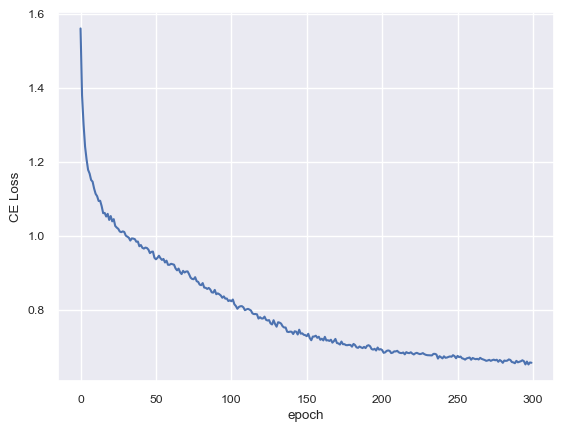

In [71]:
import time
start_time = time.time()

epochs = 300  # how many iterations
losses = []

for i in range(epochs):
    i+=1
    y_pred = model.forward(cats, conts)
    loss = criterion(y_pred, y)
    losses.append(loss.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')
        print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsedi

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsedi
plt.plot(range(epochs), losses)
plt.ylabel('CE Loss')
plt.xlabel('epoch');

In [72]:
ann_prediction=[None]*50
ann_test_err=[None]*50

with torch.no_grad():
    for i in range(50):
        ann_test = pd.concat([X_test[i], y_test[i]], axis=1)
        cats_test, conts_test, y_tensor = dl_data_to_tensor(ann_test)
        ann_test_pred = model(cats_test, conts_test)
        loss = criterion(ann_test_pred, y_tensor)
        ann_prediction[i] = ann_test_pred.argmax(dim=1).numpy()
        ann_test_err[i] = sum(y_test[i].to_numpy()!=ann_prediction[i])/len(X_test[i])

<Axes: >

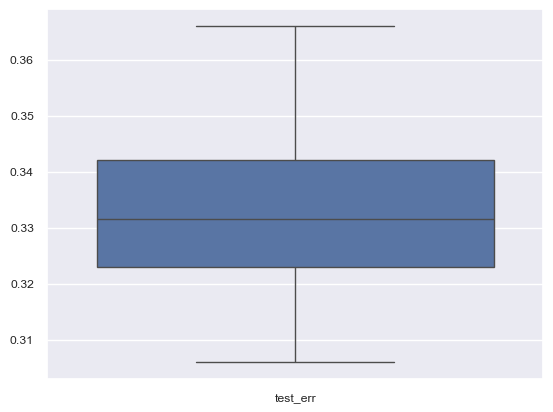

In [73]:
ann_test_err = pd.DataFrame(ann_test_err, columns = ['test_err'])
model=['ANN']*50
ann_test_err['Model']=model
sns.boxplot(ann_test_err)

## 7. Model Checking & Select Models: Sample Data 1

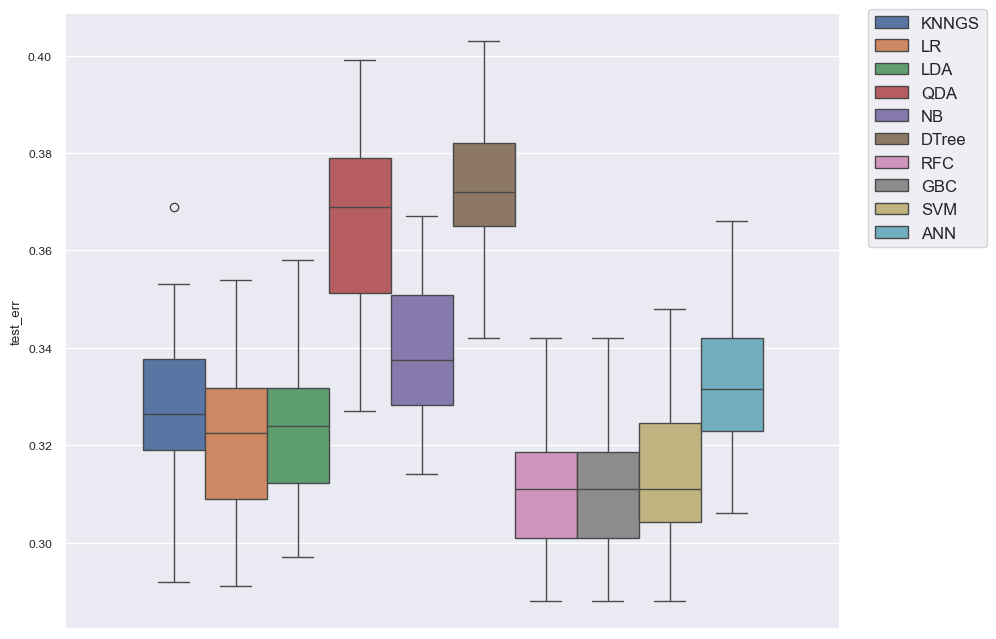

In [74]:
test_error = pd.concat([knngs_test_err, lr_test_err, lda_test_err, qda_test_err,nb_test_err, 
                        dtreegs_test_err,rfcgs_test_err, gbcgs_test_err, svmgs_test_err, ann_test_err], axis=0)

plt.subplots(figsize =(10,8))
sns.boxplot(data=test_error, y="test_err", hue="Model")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.02), fontsize=12)

In [ ]:
test_error_10k = test_error

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(test_error_10k)

In [75]:
test_error.groupby(['Model']).mean()

,test_err
Model,
ANN,0.33314
DTree,0.37312
GBC,0.31074
KNNGS,0.32846
LDA,0.32328
LR,0.32144
NB,0.33806
QDA,0.36574
RFC,0.31074


## 8. Sample and Split: 2st Trial

## **Sample 2: random sample 100k observations as training set; random sample 50 test sets, each of which has 5,000 observations**

In [76]:
# Set seed to make the results reproducible
np.random.seed(1000) 

# Get index for 100,000 training data points out of 991,263 observations
training_index = np.random.choice(range(991263), 100000)

In [77]:
# Sample the training data set to contain 100,000 observations for faster propotype
training = data.iloc[training_index]
X_train = training.iloc[:,0:-1]  
y_train = training[Y_col_name]

In [78]:
# Randomly sample 50 test data sets from the rest 990,263 observations. Each contains 5,000 observations
test_pool = data.drop(index=training_index)
X_test = [None]*50
y_test = [None]*50

for i in range(50):  
    testdata=test_pool.sample(n=5000, random_state=i) 
    X_test[i] = testdata.iloc[:,0:-1]
    y_test[i] = testdata[Y_col_name]

In [79]:
y_train.groupby(y_train).count()

smoker
1    60786
2    17603
3    21611
Name: smoker, dtype: int64

## 9. Fit Classification Models: Sample Data 2

## (1) KNN

In [80]:
parameters = {'n_neighbors': [1, 5, 10, 50, 100, 500, 1000], 
              'weights': ['uniform', 'distance']} 
  
knngs = GridSearchCV(neighbors.KNeighborsClassifier(), parameters, cv=10, 
                     scoring='accuracy', return_train_score=False,verbose=1,error_score='raise')
  
# fitting the model for grid search
knngs.fit(X_train, y_train)
knngs.best_params_   

Fitting 10 folds for each of 14 candidates, totalling 140 fits


{'n_neighbors': 100, 'weights': 'distance'}

<Axes: >

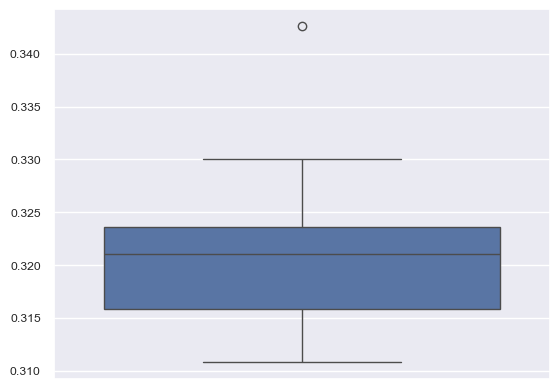

In [81]:
knngs_prediction=[None]*50
knngs_test_err=[None]*50

for i in range(50):
    knngs_prediction[i] = knngs.predict(X_test[i])
    knngs_test_err[i] = sum(y_test[i]!=knngs_prediction[i])/len(X_test[i])
sns.boxplot(knngs_test_err)

In [82]:
knngs_test_err = pd.DataFrame(knngs_test_err, columns = ['test_err'])
model=['KNNGS']*50
knngs_test_err['Model']=model
knngs_test_err.head()

,test_err,Model
0,0.3198,KNNGS
1,0.3120,KNNGS
2,0.3216,KNNGS
3,0.3178,KNNGS
4,0.3224,KNNGS


## (2) Logistic Regression

In [83]:
lr = LogisticRegression(penalty='l2',max_iter=200,solver='newton-cg')
lr.fit(X_train,y_train)

LogisticRegression(max_iter=200, solver='newton-cg')

<Axes: >

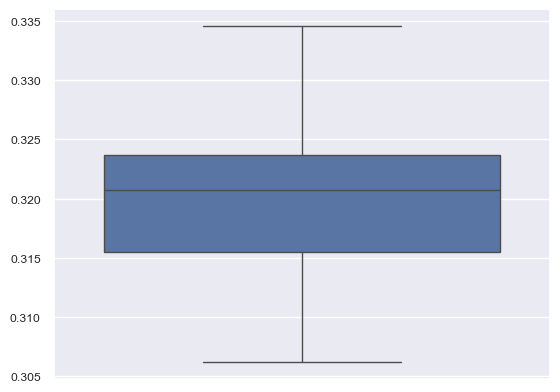

In [84]:
lr_prediction=[None]*50
lr_test_err=[None]*50

for i in range(50):
    lr_prediction[i] = lr.predict(X_test[i])
    lr_test_err[i] = sum(y_test[i]!=lr_prediction[i])/len(X_test[i])
sns.boxplot(lr_test_err)

In [85]:
lr_test_err = pd.DataFrame(lr_test_err, columns = ['test_err'])
model=['LR']*50
lr_test_err['Model']=model
lr_test_err.head()

,test_err,Model
0,0.3230,LR
1,0.3176,LR
2,0.3194,LR
3,0.3186,LR
4,0.3224,LR


## (3) LDA, QDA, NB

**A. LDA**

In [86]:
lda = LinearDiscriminantAnalysis(store_covariance=True)
lda.fit(X_train,y_train)

LinearDiscriminantAnalysis(store_covariance=True)

<Axes: >

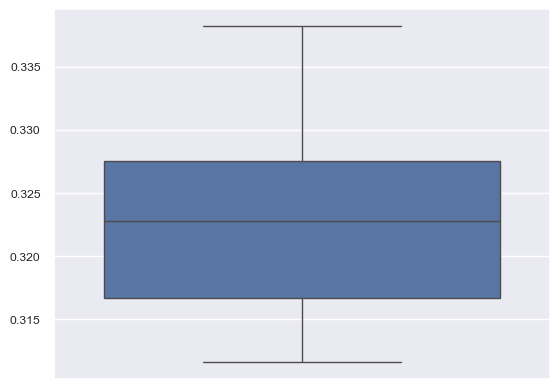

In [87]:
lda_prediction=[None]*50
lda_test_err=[None]*50

for i in range(50):
    lda_prediction[i] = lda.predict(X_test[i])
    lda_test_err[i] = sum(y_test[i]!=lda_prediction[i])/len(X_test[i])
sns.boxplot(lda_test_err)   

In [88]:
lda_test_err = pd.DataFrame(lda_test_err, columns = ['test_err'])
model=['LDA']*50
lda_test_err['Model']=model
lda_test_err.head()

,test_err,Model
0,0.3248,LDA
1,0.3206,LDA
2,0.3210,LDA
3,0.3176,LDA
4,0.3278,LDA


**B. QDA**

In [89]:
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(X_train,y_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

<Axes: >

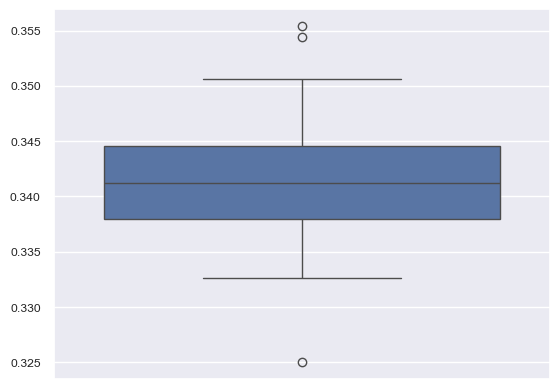

In [90]:
qda_prediction=[None]*50
qda_test_err=[None]*50

for i in range(50):
    qda_prediction[i] = qda.predict(X_test[i])
    qda_test_err[i] = sum(y_test[i]!=qda_prediction[i])/len(X_test[i])
sns.boxplot(qda_test_err)

In [91]:
qda_test_err = pd.DataFrame(qda_test_err, columns = ['test_err'])
model=['QDA']*50
qda_test_err['Model']=model
qda_test_err.head()

,test_err,Model
0,0.3434,QDA
1,0.3412,QDA
2,0.3434,QDA
3,0.3358,QDA
4,0.3412,QDA


**C. NB**

In [92]:
NB = GaussianNB()
NB.fit(X_train,y_train)

GaussianNB()

<Axes: >

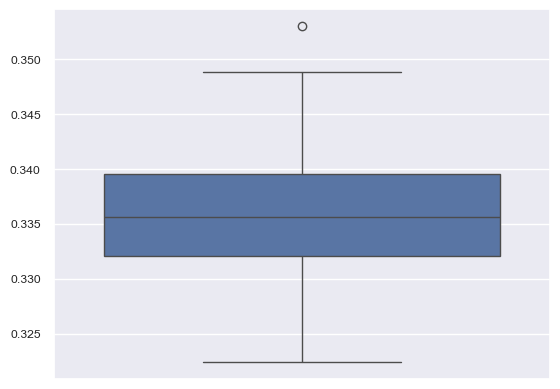

In [93]:
nb_prediction=[None]*50
nb_test_err=[None]*50

for i in range(50):
    nb_prediction[i] = NB.predict(X_test[i])
    nb_test_err[i] = sum(y_test[i]!=nb_prediction[i])/len(X_test[i])
sns.boxplot(nb_test_err)

In [94]:
nb_test_err = pd.DataFrame(nb_test_err, columns = ['test_err'])
model=['NB']*50
nb_test_err['Model']=model
nb_test_err.head()

,test_err,Model
0,0.3402,NB
1,0.3326,NB
2,0.3320,NB
3,0.3280,NB
4,0.3382,NB


## (4) Tree-based, Bagging, Random Forest, Boosting

**A. Decision Tree**

In [95]:
parameters = {'criterion': ['gini', 'entropy', 'log_loss'],
             'min_samples_split': [2,5,10]} 
dtreegs = GridSearchCV(DecisionTreeClassifier(), parameters, n_jobs=-1, cv=10)
dtreegs.fit(X_train, y_train)
dtreegs.best_params_

{'criterion': 'entropy', 'min_samples_split': 2}

<Axes: >

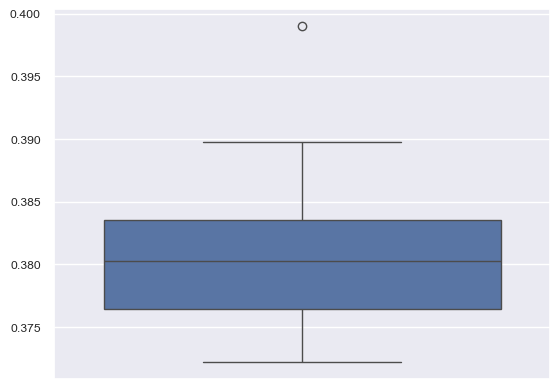

In [96]:
dtreegs_prediction=[None]*50
dtreegs_test_err=[None]*50

for i in range(50):
    dtreegs_prediction[i] = dtreegs.predict(X_test[i])
    dtreegs_test_err[i] = sum(y_test[i]!=dtreegs_prediction[i])/len(X_test[i])
sns.boxplot(dtreegs_test_err)

In [97]:
dtreegs_test_err = pd.DataFrame(dtreegs_test_err, columns = ['test_err'])
model=['DTree']*50
dtreegs_test_err['Model']=model
dtreegs_test_err.head()

,test_err,Model
0,0.3766,DTree
1,0.3826,DTree
2,0.3802,DTree
3,0.3886,DTree
4,0.3990,DTree


**B. Random Forest**

In [98]:
parameters = {'n_estimators': [5, 10, 100, 500],
             'criterion': ['gini', 'entropy', 'log_loss'],
             'min_samples_split': [2,5,10]} 

rfcgs = GridSearchCV(RandomForestClassifier(), parameters, n_jobs=-1, cv=10)
rfcgs.fit(X_train, y_train)
rfcgs.best_params_

{'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 500}

<Axes: >

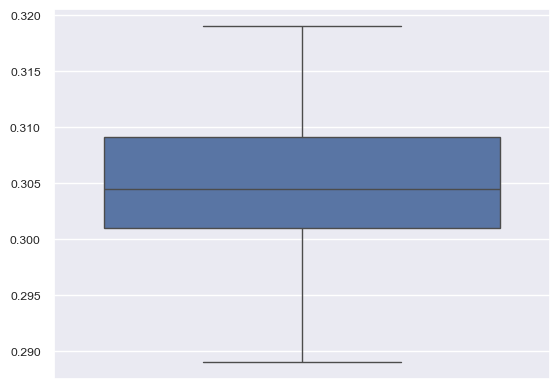

In [99]:
rfcgs_prediction=[None]*50
rfcgs_test_err=[None]*50

for i in range(50):
    rfcgs_prediction[i] = rfcgs.predict(X_test[i])
    rfcgs_test_err[i] = sum(y_test[i]!=rfcgs_prediction[i])/len(X_test[i])
sns.boxplot(rfcgs_test_err)

In [100]:
rfcgs_test_err = pd.DataFrame(rfcgs_test_err, columns = ['test_err'])
model=['RFC']*50
rfcgs_test_err['Model']=model
rfcgs_test_err.head()

,test_err,Model
0,0.3156,RFC
1,0.3044,RFC
2,0.3078,RFC
3,0.3042,RFC
4,0.3054,RFC


## (6) ANN

**A. Data Pre-processing**

In [101]:
# Separate categorical from continuous columns

cat_cols = ['sex', 'hear_left', 'hear_right']
y_col = [Y_col_name]
cont_cols = [col for col in X_train.columns if col not in cat_cols + y_col]

In [102]:
def dl_data_to_tensor(dl_data):
    # Convert our four categorical columns to category dtypes.
    for cat in cat_cols:
        dl_data[cat] = dl_data[cat].astype('category')
    # Combine the four categorical columns into one input array
    cats = np.stack([dl_data[col].cat.codes.values for col in cat_cols], 1)
    # Convert categorical variables to a tensor
    cats = torch.tensor(cats, dtype=torch.int64)
    # Convert continuous variables to a tensor
    conts = np.stack([dl_data[col].values for col in cont_cols], 1)
    conts = torch.tensor(conts, dtype=torch.float)
    # Convert labels to a tensor
    y = torch.tensor(dl_data[y_col].values).flatten()
    return cats, conts, y

In [103]:
cats, conts, y = dl_data_to_tensor(pd.concat([X_train, y_train], axis=1))
print(cats[:5])
print(conts[:5])
print(y[:5])

tensor([[0, 1, 1],
        [0, 1, 1],
        [0, 1, 1],
        [0, 1, 1],
        [1, 1, 1]])
tensor([[ 1.6814e-01,  1.3745e+00,  5.3667e-01, -1.8816e-02, -1.4402e-01,
         -4.2895e-01, -1.1987e+00, -1.5222e+00, -2.2438e-01,  3.2192e-01,
          2.3577e-01,  5.2905e-01, -5.3953e-01,  5.4899e-01,  8.2235e-02,
         -2.1239e-01, -1.4276e-01, -3.9936e-01],
        [-5.3702e-01,  8.3585e-01,  1.3358e+00,  1.9621e+00,  1.4583e-01,
         -4.2895e-01,  5.2031e-01,  1.4103e+00, -4.3116e-01, -1.4369e-01,
         -4.0236e-01,  3.6165e-01, -6.0803e-01, -5.8675e-01, -1.2586e-01,
         -2.5495e-01,  8.5297e-02, -5.1835e-01],
        [ 1.2259e+00, -2.4137e-01, -2.6242e-01,  1.8970e-01,  1.4583e-01,
          1.5325e-01,  3.8972e-02, -4.0985e-01, -2.6573e-01,  1.9259e-01,
          2.9378e-01,  5.0115e-01, -8.4287e-01,  8.0137e-01,  8.2235e-02,
          4.2797e-04,  4.7288e-02,  3.6934e-02],
        [-5.3702e-01,  1.3745e+00,  2.5344e+00,  1.0238e+00,  7.2555e-01,
          7.3545e

**B. Set an embedding size**

In [104]:
# This will set embedding sizes for sex,hear_left, hear_right, urine_protein
cat_szs = [X_train[col].nunique() for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(2, 1), (2, 1), (2, 1)]

In [105]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)

        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont

        for i in layers:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))

        self.layers = nn.Sequential(*layerlist)

    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)

        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [106]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], Y_class_num, [500, 400, 200,100], p=0.5) # out_sz=2

**C. Define loss function and optimizer**

In [107]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

**D. Train the model**

epoch:   1  loss: 1.56382871

Duration: 7 seconds
epoch:  26  loss: 1.01915252

Duration: 139 seconds
epoch:  51  loss: 0.95170182

Duration: 266 seconds
epoch:  76  loss: 0.88592935

Duration: 382 seconds
epoch: 101  loss: 0.82307845

Duration: 500 seconds
epoch: 126  loss: 0.76285493

Duration: 610 seconds
epoch: 151  loss: 0.72984713

Duration: 722 seconds
epoch: 176  loss: 0.71558321

Duration: 834 seconds
epoch: 201  loss: 0.70640367

Duration: 944 seconds
epoch: 226  loss: 0.69831336

Duration: 1052 seconds
epoch: 251  loss: 0.69449544

Duration: 1165 seconds
epoch: 276  loss: 0.68813217

Duration: 1278 seconds
epoch: 300  loss: 0.68321186

Duration: 1392 seconds


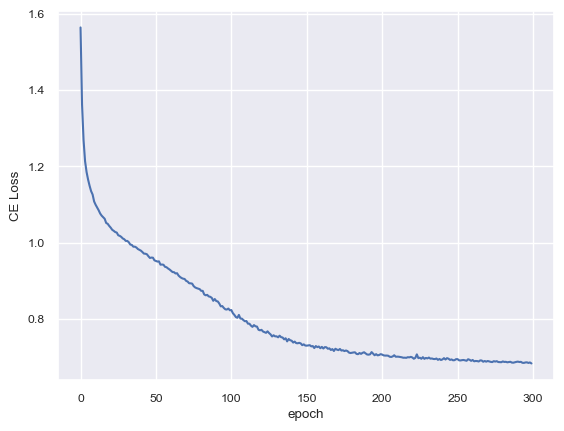

In [108]:
import time
start_time = time.time()

epochs = 300  # how many iterations
losses = []

for i in range(epochs):
    i+=1
    y_pred = model.forward(cats, conts)
    loss = criterion(y_pred, y)
    losses.append(loss.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')
        print(f'Duration: {time.time() - start_time:.0f} seconds') # print the time elapsedi

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'Duration: {time.time() - start_time:.0f} seconds') # print the time elapsedi
plt.plot(range(epochs), losses)
plt.ylabel('CE Loss')
plt.xlabel('epoch');

In [109]:
ann_prediction=[None]*50
ann_test_err=[None]*50

with torch.no_grad():
    for i in range(50):
        ann_test = pd.concat([X_test[i], y_test[i]], axis=1)
        cats_test, conts_test, y_tensor = dl_data_to_tensor(ann_test)
        ann_test_pred = model(cats_test, conts_test)
        loss = criterion(ann_test_pred, y_tensor)
        ann_prediction[i] = ann_test_pred.argmax(dim=1).numpy()
        ann_test_err[i] = sum(y_test[i].to_numpy()!=ann_prediction[i])/len(X_test[i])

<Axes: >

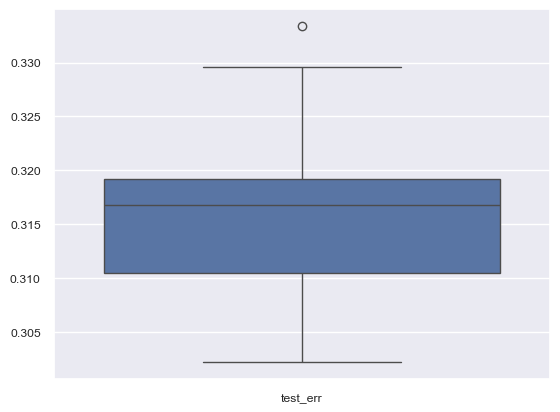

In [110]:
ann_test_err = pd.DataFrame(ann_test_err, columns = ['test_err'])
model=['ANN']*50
ann_test_err['Model']=model
sns.boxplot(ann_test_err)

## 10. Model Checking & Select Models: Sample Data 2

<Axes: xlabel='Model', ylabel='test_err'>

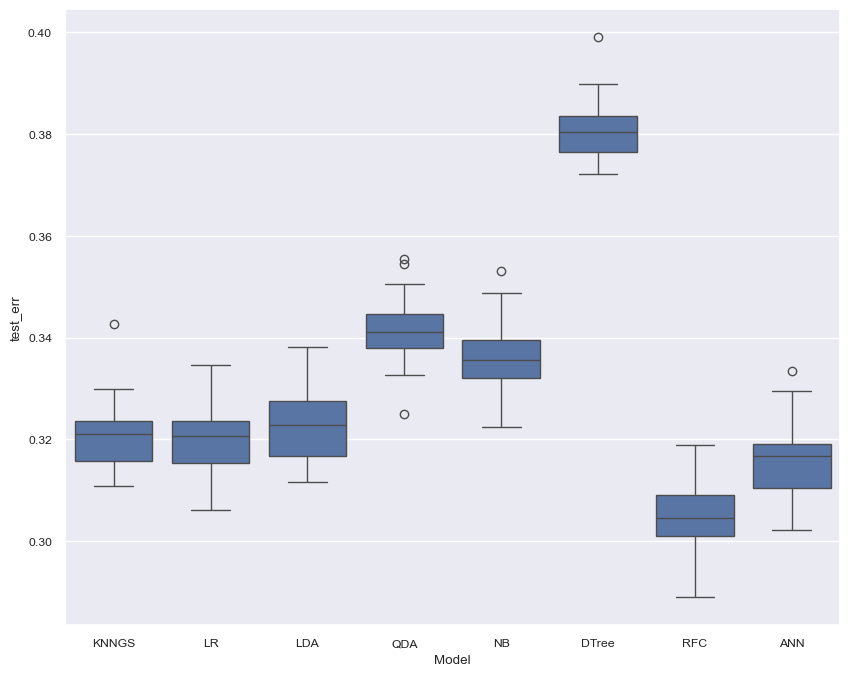

In [113]:
test_error = pd.concat([knngs_test_err, lr_test_err, lda_test_err, qda_test_err,nb_test_err, 
                        dtreegs_test_err,rfcgs_test_err, ann_test_err], axis=0)

plt.subplots(figsize =(10,8))
sns.boxplot(data=test_error, y="test_err", x="Model")

In [116]:
test_error_100k = test_error

In [117]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(test_error_100k)

    test_err  Model
0     0.3198  KNNGS
1     0.3120  KNNGS
2     0.3216  KNNGS
3     0.3178  KNNGS
4     0.3224  KNNGS
5     0.3300  KNNGS
6     0.3128  KNNGS
7     0.3112  KNNGS
8     0.3426  KNNGS
9     0.3230  KNNGS
10    0.3152  KNNGS
11    0.3156  KNNGS
12    0.3256  KNNGS
13    0.3160  KNNGS
14    0.3262  KNNGS
15    0.3252  KNNGS
16    0.3272  KNNGS
17    0.3108  KNNGS
18    0.3270  KNNGS
19    0.3218  KNNGS
20    0.3112  KNNGS
21    0.3158  KNNGS
22    0.3234  KNNGS
23    0.3288  KNNGS
24    0.3128  KNNGS
25    0.3190  KNNGS
26    0.3234  KNNGS
27    0.3224  KNNGS
28    0.3214  KNNGS
29    0.3134  KNNGS
30    0.3182  KNNGS
31    0.3168  KNNGS
32    0.3226  KNNGS
33    0.3220  KNNGS
34    0.3236  KNNGS
35    0.3196  KNNGS
36    0.3182  KNNGS
37    0.3290  KNNGS
38    0.3232  KNNGS
39    0.3206  KNNGS
40    0.3294  KNNGS
41    0.3188  KNNGS
42    0.3184  KNNGS
43    0.3258  KNNGS
44    0.3150  KNNGS
45    0.3152  KNNGS
46    0.3124  KNNGS
47    0.3248  KNNGS
48    0.3224  KNNGS


In [112]:
test_error.groupby(['Model']).mean()

,test_err
Model,
ANN,0.315492
DTree,0.380472
KNNGS,0.320596
LDA,0.322824
LR,0.319852
NB,0.335796
QDA,0.341740
RFC,0.304768


## Final: Apply the selected models & best parameters to the whole dataset

**Training & Test split**

In [118]:
X=data.iloc[:,0:-1]
y=data[Y_col_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [119]:
X_train.shape

(693884, 21)

In [120]:
X_test.shape

(297379, 21)

**(1) KNN**

In [121]:
start_time = time.time()

knnmodel = neighbors.KNeighborsClassifier(n_neighbors=100, weights='distance')
knnmodel.fit(X_train, y_train)
knn_predict = knnmodel.predict(X_test)

print(classification_report(y_test,knn_predict))
print(confusion_matrix(y_test,knn_predict))
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsedi

              precision    recall  f1-score   support

           1       0.82      0.82      0.82    180973
           2       0.43      0.37      0.40     52485
           3       0.50      0.55      0.52     63921

    accuracy                           0.69    297379
   macro avg       0.58      0.58      0.58    297379
weighted avg       0.68      0.69      0.68    297379

[[149271  14080  17622]
 [ 14838  19477  18170]
 [ 17054  11615  35252]]

Duration: 594 seconds


**(2) Logistic Regression**

In [122]:
start_time = time.time()

lrmodel = LogisticRegression(penalty='l2',max_iter=200,solver='newton-cg')
lrmodel.fit(X_train,y_train)
lrmodel_predict = lrmodel.predict(X_test)

print(classification_report(y_test,lrmodel_predict))
print(confusion_matrix(y_test,lrmodel_predict))
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsedi

              precision    recall  f1-score   support

           1       0.83      0.80      0.81    180973
           2       0.44      0.35      0.39     52485
           3       0.48      0.63      0.55     63921

    accuracy                           0.68    297379
   macro avg       0.59      0.59      0.58    297379
weighted avg       0.69      0.68      0.68    297379

[[143937  13737  23299]
 [ 14614  18333  19538]
 [ 14046   9808  40067]]

Duration: 62 seconds


**(3) NB**

In [123]:
start_time = time.time()

NB = GaussianNB()
NB.fit(X_train,y_train)
NB_predict=NB.predict(X_test)

print(classification_report(y_test,NB_predict))
print(confusion_matrix(y_test,NB_predict))
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsedi

              precision    recall  f1-score   support

           1       0.86      0.77      0.81    180973
           2       0.41      0.43      0.42     52485
           3       0.45      0.57      0.51     63921

    accuracy                           0.67    297379
   macro avg       0.57      0.59      0.58    297379
weighted avg       0.69      0.67      0.68    297379

[[139131  17079  24763]
 [ 10306  22435  19744]
 [ 11883  15368  36670]]

Duration: 4 seconds


**(4) LDA**

In [124]:
start_time = time.time()

ldamodel = LinearDiscriminantAnalysis(store_covariance=True)
ldamodel.fit(X_train,y_train)
ldamodel_predict=ldamodel.predict(X_test)

print(classification_report(y_test,ldamodel_predict))
print(confusion_matrix(y_test,ldamodel_predict))
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsedi

              precision    recall  f1-score   support

           1       0.94      0.73      0.82    180973
           2       0.41      0.50      0.45     52485
           3       0.46      0.68      0.55     63921

    accuracy                           0.68    297379
   macro avg       0.61      0.64      0.61    297379
weighted avg       0.75      0.68      0.70    297379

[[131647  21484  27842]
 [  3342  26097  23046]
 [  4860  15323  43738]]

Duration: 11 seconds


**(5) Random Forest**

In [144]:
start_time = time.time()

rfcmodel=RandomForestClassifier(n_estimators=500, criterion='entropy', min_samples_split=2)
rfcmodel.fit(X_train, y_train)
rfcmodel_prediction = rfcmodel.predict(X_test)

print(classification_report(y_test,rfcmodel_prediction))
print(confusion_matrix(y_test,rfcmodel_prediction))
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsedi

              precision    recall  f1-score   support

           1       0.84      0.82      0.83    180973
           2       0.44      0.39      0.41     52485
           3       0.51      0.60      0.55     63921

    accuracy                           0.70    297379
   macro avg       0.60      0.60      0.60    297379
weighted avg       0.70      0.70      0.70    297379

[[149258  14367  17348]
 [ 13502  20269  18714]
 [ 14597  11092  38232]]

Duration: 1440 seconds


**(6) Gradient Boosting Classifier**

In [145]:
start_time = time.time()

gbcmodel=GradientBoostingClassifier(n_estimators= 100, min_samples_split= 2, learning_rate = 0.5, max_depth=1)
gbcmodel.fit(X_train, y_train)
gbcmodel_prediction = gbcmodel.predict(X_test)

print(classification_report(y_test,gbcmodel_prediction))
print(confusion_matrix(y_test,gbcmodel_prediction))

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsedi

              precision    recall  f1-score   support

           1       0.84      0.82      0.83    180973
           2       0.44      0.37      0.40     52485
           3       0.51      0.61      0.56     63921

    accuracy                           0.70    297379
   macro avg       0.60      0.60      0.60    297379
weighted avg       0.70      0.70      0.70    297379

[[148794  13610  18569]
 [ 14014  19400  19071]
 [ 13944  10872  39105]]

Duration: 246 seconds


**(7) ANN**

**A. Data Pre-processing**

In [154]:
cat_cols = ['sex', 'hear_left', 'hear_right']
y_col = [Y_col_name]
cont_cols = [col for col in data.columns if col not in cat_cols + y_col]

In [155]:
def dl_data_to_tensor(dl_data):
    # Convert our four categorical columns to category dtypes.
    for cat in cat_cols:
        dl_data[cat] = dl_data[cat].astype('category')
    # Combine the four categorical columns into one input array
    cats = np.stack([dl_data[col].cat.codes.values for col in cat_cols], 1)
    # Convert categorical variables to a tensor
    cats = torch.tensor(cats, dtype=torch.int64)
    # Convert continuous variables to a tensor
    conts = np.stack([dl_data[col].values for col in cont_cols], 1)
    conts = torch.tensor(conts, dtype=torch.float)
    # Convert labels to a tensor
    y = torch.tensor(dl_data[y_col].values).flatten()
    return cats, conts, y

In [156]:
cats, conts, y = dl_data_to_tensor(pd.concat([X_train, y_train], axis=1))
print(cats[:5])
print(conts[:5])
print(y[:5])

tensor([[0, 1, 1],
        [0, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [0, 1, 1]])
tensor([[-1.2422e+00,  2.9724e-01, -6.6196e-01, -8.5287e-01,  1.5951e+00,
          1.6087e+00, -9.9246e-01, -1.5222e+00, -7.6201e-01,  1.4085e-01,
          1.1975e-01,  2.5005e-01, -3.4383e-01,  6.7518e-01,  4.9843e-01,
         -8.4699e-02,  7.3145e-01,  5.9222e-01],
        [ 1.5785e+00,  2.9724e-01, -2.6242e-01, -1.2307e-01, -4.3388e-01,
          7.3545e-01, -2.3608e-01, -4.0985e-01, -5.1387e-01, -8.1624e-01,
          2.3577e-01, -1.0054e+00, -1.1130e-02,  3.5970e-01,  4.9843e-01,
         -2.1239e-01, -4.0882e-01, -4.9852e-01],
        [-5.3702e-01, -2.4137e-01, -1.0615e+00, -1.3742e+00, -1.4402e-01,
          1.5325e-01, -7.8618e-01, -4.0985e-01, -5.5523e-01,  1.5894e+00,
          3.7241e-03,  2.1751e+00, -5.1996e-01, -1.0915e+00, -3.3396e-01,
         -1.2726e-01, -4.8484e-01, -5.5801e-01],
        [-1.2422e+00,  2.9724e-01, -2.6242e-01, -4.3584e-01,  7.2555e-01,
          7.3545e

**B. Set an embedding size**

In [157]:
# This will set embedding sizes for sex,hear_left, hear_right, urine_protein
cat_szs = [data[col].nunique() for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(2, 1), (2, 1), (2, 1)]

In [158]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)

        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont

        for i in layers:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))

        self.layers = nn.Sequential(*layerlist)

    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)

        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [159]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], Y_class_num, [500, 400, 200,100], p=0.5) # out_sz=2

**C. Define loss function and optimizer**

In [160]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

**D. Train the model**

epoch:   1  loss: 1.55399227
Duration: 30 seconds
epoch:  26  loss: 1.00614536
Duration: 674 seconds
epoch:  51  loss: 0.93820214
Duration: 1331 seconds
epoch:  76  loss: 0.87166995
Duration: 1869 seconds
epoch: 101  loss: 0.79996568
Duration: 2414 seconds
epoch: 126  loss: 0.75072175
Duration: 3028 seconds
epoch: 151  loss: 0.72515512
Duration: 3684 seconds
epoch: 176  loss: 0.70847458
Duration: 4352 seconds
epoch: 201  loss: 0.69869989
Duration: 4823 seconds
epoch: 226  loss: 0.69282687
Duration: 5549 seconds
epoch: 251  loss: 0.68852806
Duration: 6371 seconds
epoch: 276  loss: 0.68393332
Duration: 7079 seconds
epoch: 300  loss: 0.68277574
Duration: 7630 seconds


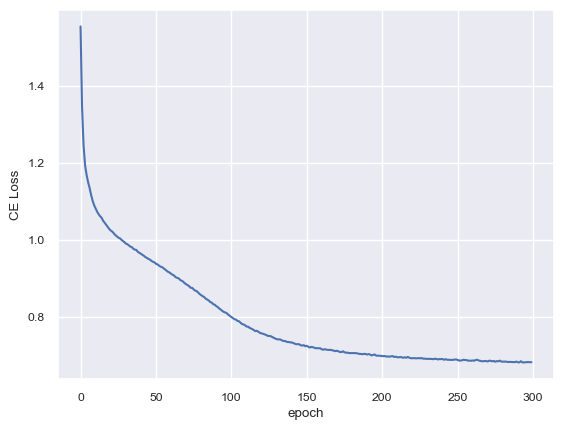

In [161]:
start_time = time.time()

epochs = 300  # how many iterations
losses = []

for i in range(epochs):
    i+=1
    y_pred = model.forward(cats, conts)
    loss = criterion(y_pred, y)
    losses.append(loss.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')
        print(f'Duration: {time.time() - start_time:.0f} seconds') # print the time elapsedi

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'Duration: {time.time() - start_time:.0f} seconds') # print the time elapsedi
plt.plot(range(epochs), losses)
plt.ylabel('CE Loss')
plt.xlabel('epoch');

In [162]:
start_time = time.time()
with torch.no_grad():
    ann_test = pd.concat([X_test, y_test], axis=1)
    cats_test, conts_test, y_tensor = dl_data_to_tensor(ann_test)
    ann_test_pred = model(cats_test, conts_test)
    ann_prediction = ann_test_pred.argmax(dim=1).numpy()


print(classification_report(y_test,ann_prediction))
print(confusion_matrix(y_test,ann_prediction))

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsedi

/Users/chunfengh/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chunfengh/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chunfengh/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.82      0.83      0.82    180973
           2       0.43      0.33      0.38     52485
           3       0.51      0.58      0.54     63921

    accuracy                           0.69    297379
   macro avg       0.44      0.44      0.43    297379
weighted avg       0.68      0.69      0.68    297379

[[     0      0      0      0]
 [     2 150793  12825  17353]
 [     1  16950  17414  18120]
 [     0  17121  10030  36770]]

Duration: 4 seconds


In [2]:
7630/60

127.16666666666667